 # Baseline - Calibration

In [87]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker
import ast
import json

from sklearn import preprocessing
import re
from libs import read_df

%config IPCompleter.greedy=True
%matplotlib notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 10]

POINT_PLOT_DODGE = 0.15
sns.set(font_scale=1.25, style="white")
FIGSIZE = [6, 6]

In [54]:
measurements = list()
experiment_labels = [
#    "ndr-bypass-single",
#    "ndr-bypass-single-ht",
    'l3fwd-1thread-trex-pdr0.01',
    'l3fwd-1thread-trex-pdr0.1',
]

for experiment in experiment_labels:

    output_dir = f"../output/{experiment}"

    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        calls = 0
        no_buf = 0
        vector_rate = 0.0
        nworkers = 0

        for file in files:
            none, label, packet_size, repeat = direc.replace(output_dir, "").split("/")

            if "vpp" in file:
                with open(
                    direc + "/" + file, "r", encoding="utf8", errors="ignore"
                ) as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])

                        if (
                            "/interfaces/dev0/rx-no-buf" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            no_buf = int(p[3])

                        if "/err/dev1-tx/Tx" in p and "2]:" in p[2] and "[0" in p[0]:
                            drops = int(p[3])

                        if (
                            "/nodes/dev1-output/vectors" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            vectors = int(p[3])

                        if "/sys/vector_rate" in p:
                            vector_rate = float(p[0])

                        if "/sys/num_worker_threads" in p:
                            nworkers = float(p[0])

                        if (
                            "/nodes/dev1-output/calls" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            calls = int(p[3])

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = json.loads(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue

        total_errors = misses + drops + no_buf
        
        measurements.append(
            {
                "total_rx_L1": int(t["results"]["total_tx_L1"]),
                "total_tx_L1": int(t["results"]["total_rx_L1"]),
                "total_tx_pps": int(t["results"]["tx_pps"]),
                "total_rx_pps": int(t["results"]["rx_pps"]),
                "VNF": label,
                "ST": "SMT" if "ht" in experiment else "ST",
                'PDR (%)': 0.1 if '0.1' in experiment else 0.01,
                #'disabled': 'disabled' if 'disabled' in experiment else 'bypass',
                "nworkers": nworkers,
                "packet_size": int(packet_size),
                "misses": misses,
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,
                "vector_rate": vector_rate,
                "call": calls,
            }
        )
single_df = pd.DataFrame(measurements)

In [59]:
ixia_calb_df = pd.read_csv('../output/ixia-1thread-trex/ixia.csv')
ixia_calb_df.columns

Index(['Trial', 'Framesize', 'Iteration', 'Agg Tx Rate (% Line Rate)',
       'Agg Rx Throughput (% Line Rate)', 'Agg Rx Throughput (fps)',
       'Agg Rx Throughput (Mbps)', 'Agg Tx Count (frames)',
       'Agg Rx Count (frames)', 'Agg Frame Loss (frames)',
       'Agg Frame Loss (%)', 'Min Latency (ns)', 'Max Latency (ns)',
       'Avg Latency (ns)', 'Stream Duration (s)'],
      dtype='object')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

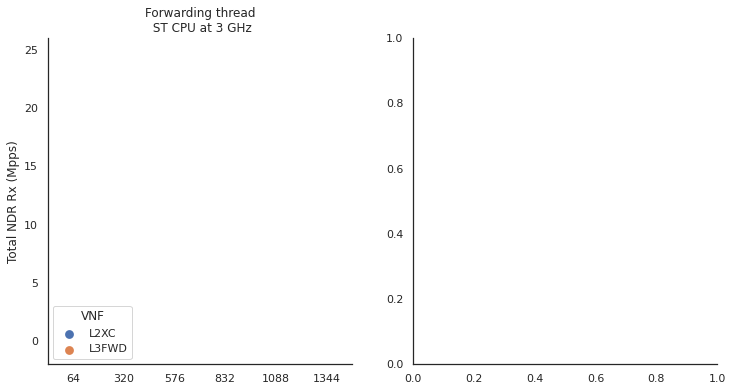

In [47]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[2*FIGSIZE[0], FIGSIZE[1]])

p_df = single_df
# p_df = p_df[p_df['packet_size'] == 64]

fig1 = sns.pointplot(
    data=p_df[p_df['ST'] == 'ST'],
    x="packet_size",
    y=p_df["total_rx_pps"] / (10**6),
    units="units",
    hue='VNF',
    ax=ax1,
    # palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    hue_order = ["L2XC", "L3FWD"],
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="",
    ylim=[-2, 26],
    title = 'Forwarding thread\n ST CPU at 3 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
ax1.legend(title='VNF', loc='lower left')

sns.despine()

fig2 = sns.pointplot(
    data=p_df[p_df['ST'] == 'SMT'],
    x="packet_size",
    y=p_df["total_rx_pps"] / (10**6),
    units="units",
    hue='VNF',
    ax=ax2,
    # palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    hue_order = ["L2XC", "L3FWD"],
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="",
    ylim=[-2, 26],
    title = 'Forwarding thread\n SMT CPU at 3 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
ax2.legend(title='VNF', loc='lower left')

sns.despine()

# fig.savefig("../output_figures/ndr_bypass_single_instance_single_thread.pdf")

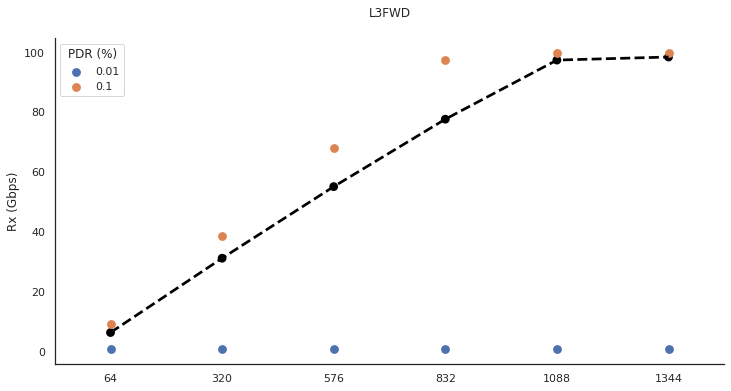

In [86]:
%matplotlib inline
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=[2*FIGSIZE[0], FIGSIZE[1]])

p_df = single_df
# p_df = p_df[p_df['packet_size'] == 64]

fig1 = sns.pointplot(
    data=p_df,
    x="packet_size",
    y=p_df["total_rx_L1"]/(10**9),
    #units="units",
    hue='PDR (%)',
    ax=ax1,
    # palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    #hue_order = ["L2XC", "L3FWD"],
    # hue_order = [64, 256, 512, 1500],
)

fig2 = sns.pointplot(
    data=ixia_calb_df,
    x="Framesize",
    y=ixia_calb_df["Agg Rx Throughput (Mbps)"]/(10**3),
    #units="units",
    ax=ax1,
    # palette = 'colorblind',
    #ci='sd',
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    color = 'black',
    join=True,
    linestyles="--",
    #linewidth=0.005,
    #hue_order = ["L2XC", "L3FWD"],
    # hue_order = [64, 256, 512, 1500],
    #label = 'NDR',
)
fig2.set_label('NDR')

ax1.set(
    ylabel="Rx (Gbps)",
    xlabel="",
  #  ylim=[-2, 26],
    title = 'L3FWD\n'
)
plt.setp(fig.lines, linewidth=1.25)
ax1.legend(title='PDR (%)', loc='upper left')

sns.despine()

# fig.savefig("../output_figures/ixia_bps.png")

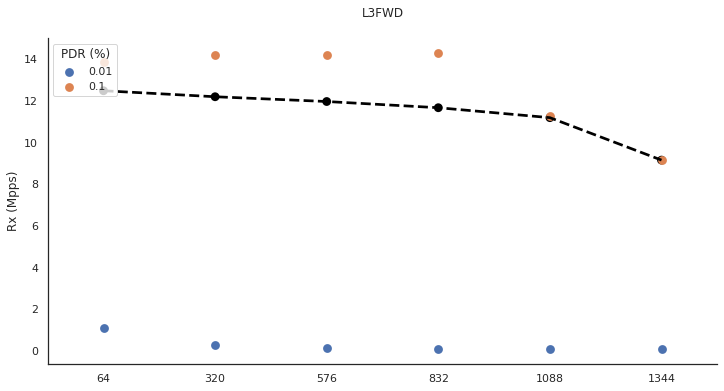

In [85]:
%matplotlib inline
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=[2*FIGSIZE[0], FIGSIZE[1]])

p_df = single_df
# p_df = p_df[p_df['packet_size'] == 64]

fig1 = sns.pointplot(
    data=p_df,
    x="packet_size",
    y=p_df["total_rx_pps"]/(10**6),
    #units="units",
    hue='PDR (%)',
    ax=ax1,
    # palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    #hue_order = ["L2XC", "L3FWD"],
    # hue_order = [64, 256, 512, 1500],
)

fig1 = sns.pointplot(
    data=ixia_calb_df,
    x="Framesize",
    y=ixia_calb_df["Agg Rx Throughput (fps)"]/(10**6),
    #units="units",
    ax=ax1,
    # palette = 'colorblind',
    #ci='sd',
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    color = 'black',
    join=True,
    linestyles="--",
    #linewidth=0.005,
    #hue_order = ["L2XC", "L3FWD"],
    # hue_order = [64, 256, 512, 1500],
)



ax1.set(
    ylabel="Rx (Mpps)",
    xlabel="",
  #  ylim=[-2, 26],
    title = 'L3FWD\n'
)
plt.setp(fig.lines, linewidth=1.25)
ax1.legend(title='PDR (%)', loc='upper left')
sns.despine()
# fig.savefig("../output_figures/ixia_pps.png")

# HQoS Baseline

## Effect of packet classifier

In [4]:
measurements = list()
experiment_labels = [
    'ndr-hqos_disabled',
    'ndr-hqos_bypass',
    'l3fwd-bypass-ndr',
    'l3fwd-disabled-ndr',
]

for experiment in experiment_labels:
    
    output_dir = f"../output/{experiment}"
    
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        calls = 0
        no_buf = 0
        vector_rate = 0.0
        nworkers = 0
        
        for file in files:
            none, label, packet_size, repeat = direc.replace(output_dir, "").split("/")
            
            if "average" in file:
                perfstat = pd.read_csv(direc + "/" + file, index_col = 'metrics')

            if "vpp" in file:
                with open(direc + "/" + file, "r", encoding="utf8", errors="ignore") as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])

                        if (
                            "/interfaces/dev0/rx-no-buf" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            no_buf = int(p[3])

                        if "/err/dev1-tx/Tx" in p and "2]:" in p[2] and "[0" in p[0]:
                            drops = int(p[3])

                        if (
                            "/nodes/dev1-output/vectors" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            vectors = int(p[3])

                        if "/sys/vector_rate" in p:
                            vector_rate = float(p[0])
                        
                        if "/sys/num_worker_threads" in p:
                            nworkers = float(p[0])

                        if (
                            "/nodes/dev1-output/calls" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            calls = int(p[3])

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = json.loads(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue
        
        metric= 'avg'
        total_errors = misses + drops + no_buf
        measurements.append(
            {
                "total_rx_L1": t["results"]["total_tx_L1"],
                "total_tx_L1": int(t["results"]["total_rx_L1"]),
                "total_tx_pps": int(t["results"]["tx_pps"]),
                "total_rx_pps": int(t["results"]["rx_pps"]),
                #"VNF": label,
                'disabled': 'disabled' if 'disabled' in experiment else 'bypass',
                'VNF': 'L3FWD' if 'l3fwd' in experiment else 'L2XC',
                #'nworkers': nworkers,
                "packet_size": int(packet_size),
                "misses": misses,
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,
                "vector_rate": vector_rate,
                "call": calls,
                
                'IPC': perfstat.loc['metric_kernel_CPI', metric],
                'Frontend Bound': perfstat.loc['metric_TMA_Frontend_Bound(%)',metric],
                'Backend Bound': perfstat.loc['metric_TMA_Backend_Bound(%)', metric],
                'Cache Bound': perfstat.loc['metric_TMA_..Memory_Bound(%)', metric],
                'Core Bound': perfstat.loc['metric_TMA_..Core_Bound(%)', metric],
                'Memory Bound': perfstat.loc['metric_TMA_....MEM_Bound(%)', metric],
                'DTLB load miss': perfstat.loc['metric_DTLB load miss latency (in core clks)', metric],
                
                'L1 Bound': perfstat.loc['metric_TMA_....L1_Bound(%)', metric],
                'L2 Bound': perfstat.loc['metric_TMA_....L2_Bound(%)', metric],
                'L3 Bound': perfstat.loc['metric_TMA_....L3_Bound(%)',metric],

            }
        )
bypass_df = pd.DataFrame(measurements)


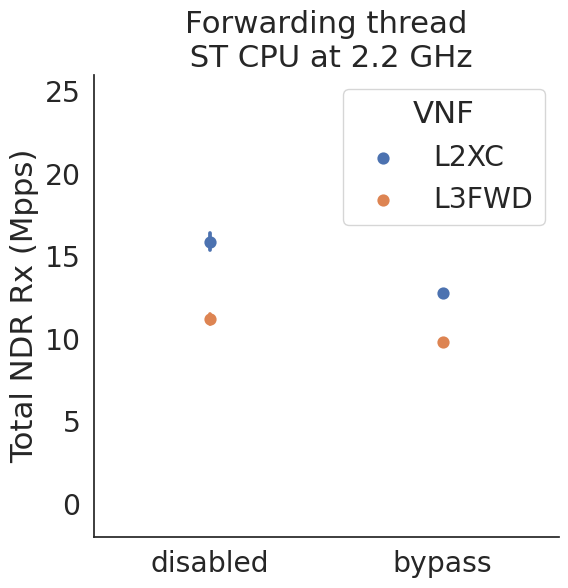

In [5]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=FIGSIZE)

p_df = bypass_df
# p_df = p_df[p_df['packet_size'] == 64]

fig1 = sns.pointplot(
    data=p_df,
    x="disabled",
    y=p_df["total_rx_pps"] / (10**6),
    units="units",
    hue='VNF',
    ax=ax1,
    # palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    #hue_order = ["L2XC", "L3FWD"],
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="",
    ylim=[-2, 26],
    title = 'Forwarding thread\n ST CPU at 2.2 GHz'
)
plt.setp(fig.lines, linewidth=1.25)
#ax1.legend(title='VNF', loc='lower left')
sns.despine()


## Multicore scaling

In [32]:
measurements = list()

experiment_labels = [
    'ndr-bypass-2worker-2200',
    'ndr-bypass-2worker-2200-ht',
    'ndr-bypass-4worker-2200',
    'ndr-bypass-4worker-2200-ht',
    'ndr-bypass-6worker-2200',
    'ndr-bypass-6worker-2200-ht',
    'ndr-bypass-8worker-2200',
    'ndr-bypass-8worker-2200-ht',
    'ndr-bypass-10worker-2200',
    'ndr-bypass-10worker-2200-ht',
    'ndr-bypass-12worker-2200-ht',
]

for experiment in experiment_labels:
    
    output_dir = f"../output/{experiment}"
    
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        calls = 0
        no_buf = 0
        vector_rate = 0.0
        nworkers = 0
        
        for file in files:
            none, label, packet_size, repeat = direc.replace(output_dir, "").split("/")
            
            if "average" in file:
                perfstat = pd.read_csv(direc + "/" + file, index_col = 'metrics')

            if "vpp" in file:
                with open(direc + "/" + file, "r", encoding="utf8", errors="ignore") as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])

                        if (
                            "/interfaces/dev0/rx-no-buf" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            no_buf = int(p[3])

                        if "/err/dev1-tx/Tx" in p and "2]:" in p[2] and "[0" in p[0]:
                            drops = int(p[3])

                        if (
                            "/nodes/dev1-output/vectors" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            vectors = int(p[3])

                        if "/sys/vector_rate" in p:
                            vector_rate = float(p[0])
                        
                        if "/sys/num_worker_threads" in p:
                            nworkers = float(p[0])

                        if (
                            "/nodes/dev1-output/calls" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            calls = int(p[3])

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = json.loads(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue
        
        metric= 'avg'
        total_errors = misses + drops + no_buf
        measurements.append(
            {
                "total_rx_L1": t["results"]["total_tx_L1"],
                "total_tx_L1": int(t["results"]["total_rx_L1"]),
                "total_tx_pps": int(t["results"]["tx_pps"]),
                "total_rx_pps": int(t["results"]["rx_pps"]),
                "VNF": label,
                'disabled': 'disabled' if 'disabled' in experiment else 'bypass',
                'nworkers': nworkers,
                'ST': 'SMT' if 'ht' in experiment else 'ST',
                "packet_size": int(packet_size),
                "misses": misses,
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,
                "vector_rate": vector_rate,
                "call": calls,
                
                'IPC': perfstat.loc['metric_kernel_CPI', metric],
                'Frontend Bound': perfstat.loc['metric_TMA_Frontend_Bound(%)',metric],
                'Backend Bound': perfstat.loc['metric_TMA_Backend_Bound(%)', metric],
                'Cache Bound': perfstat.loc['metric_TMA_..Memory_Bound(%)', metric],
                'Core Bound': perfstat.loc['metric_TMA_..Core_Bound(%)', metric],
                'Memory Bound': perfstat.loc['metric_TMA_....MEM_Bound(%)', metric],
                'DTLB load miss': perfstat.loc['metric_DTLB load miss latency (in core clks)', metric],
                
                'L1 Bound': perfstat.loc['metric_TMA_....L1_Bound(%)', metric],
                'L2 Bound': perfstat.loc['metric_TMA_....L2_Bound(%)', metric],
                'L3 Bound': perfstat.loc['metric_TMA_....L3_Bound(%)',metric],

            }
        )
multicore_df = pd.DataFrame(measurements)


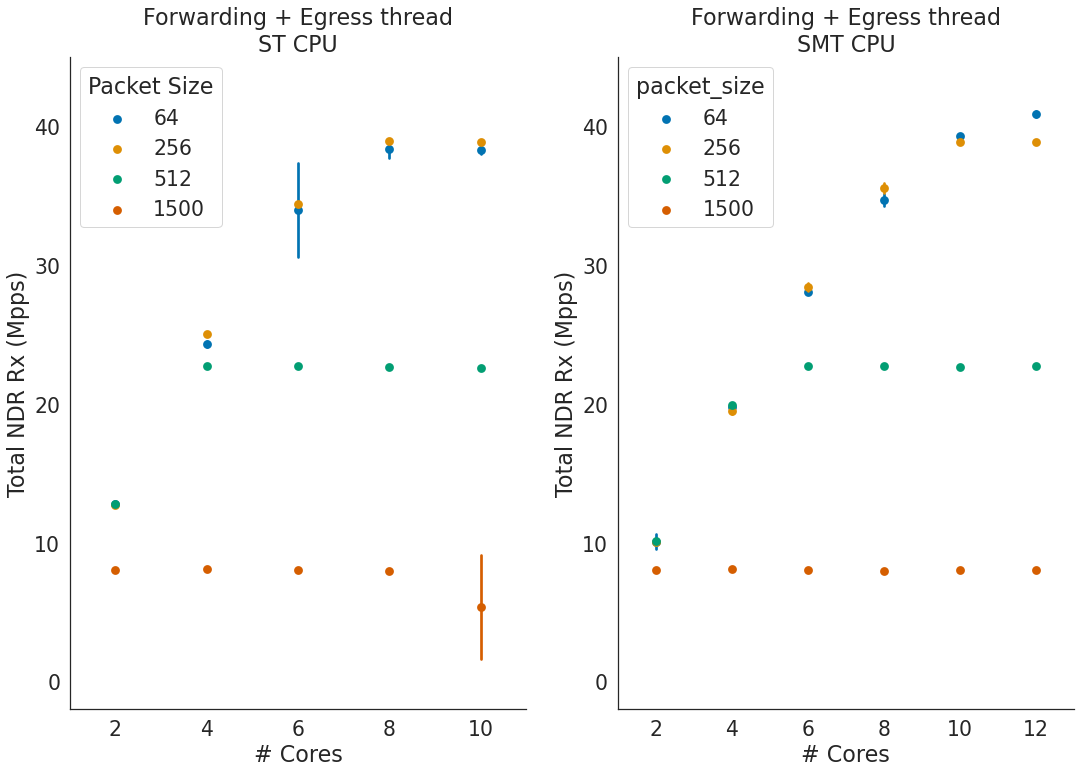

In [33]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[3*FIGSIZE[0], 2*FIGSIZE[1]])

p_df = multicore_df[multicore_df['ST'] == 'ST']
p_df = p_df[p_df['VNF'] == 'L2XC']
p_df = p_df.astype({'nworkers': int}).loc[p_df['nworkers'].isin([2,4,6,8,10,12])]

fig1 = sns.pointplot(
    data=p_df,
    x="nworkers",
    y=p_df["total_rx_pps"] / (10**6),
    units="units",
    hue='packet_size',
    ax=ax1,
    palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    label="Measured",
    #hue_order = [2, 4],
)

ax1.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="# Cores",
    ylim=[-2, 45],
    title = 'Forwarding + Egress thread\nST CPU'
)
plt.setp(fig.lines, linewidth=1.25)
ax1.legend(title='Packet Size', loc='upper left')


sns.despine()

p_df = multicore_df[multicore_df['ST'] == 'SMT']
p_df = p_df[p_df['VNF'] == 'L2XC']
p_df = p_df.astype({'nworkers': int}).loc[p_df['nworkers'].isin([2,4,6,8,10,12])]

fig2 = sns.pointplot(
    data=p_df,
    x="nworkers",
    y=p_df["total_rx_pps"] / (10**6),
    units="units",
    hue='packet_size',
    ax=ax2,
    palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    label="Measured",
    #hue_order = [2, 4],
)

ax2.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="# Cores",
    ylim=[-2, 45],
    title = 'Forwarding + Egress thread\nSMT CPU'
)
plt.setp(fig.lines, linewidth=1.25)
ax1.legend(title='Packet Size', loc='upper left')


sns.despine()

# fig.savefig("../output_figures/ndr_bypass_single_instance_single_thread.pdf")


## HQoS configs

### HQoS @ Max

In [4]:
measurements = list()
experiment_labels = [
    '1flow',
    '2flow',
    '4flow',
    '8flow',
]

for experiment in experiment_labels:
    output_dir = f"../output/hqos_max-ndr-{experiment}"
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        call = 0

        for file in files:
            none, flows, packet_size, repeat = direc.replace(output_dir, "").split("/")

            if "average" in file:
                perfstat = pd.read_csv(direc + "/" + file, index_col = 'metrics')

            if "vpp" in file:
                with open(
                    direc + "/" + file, "r", encoding="utf8", errors="ignore"
                ) as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])
                            continue

                        m = re.search(r"\[0 @ 2\]: (\d*) packets \/err\/dev1-tx\/Tx packet drops.*", line)
                        if (m):
                            drops += int(m.group(1))
                            continue

                        if (
                            "/nodes/dev0-output/vectors" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            vectors = int(p[3])
                            continue

                        if (
                            "/nodes/dev0-output/calls" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            calls = int(p[3])
                            continue

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = json.loads(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue


        metric = 'avg'
        total_errors = misses + drops
        measurements.append(
            {
                "total_rx_L1": t["results"]["total_tx_L1"],
                "total_tx_L1": int(t["results"]["total_rx_L1"]),
                "total_tx_pps": int(t["results"]["tx_pps"]),
                "total_rx_pps": int(t["results"]["rx_pps"]),
                #"VNF": label,
                #'ST': 'SMT' if 'ht' in experiment else 'ST',
                'ntc': experiment,
                "packet_size": int(packet_size),
                "misses": misses,
                'flows': int(flows),
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                #"no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,

                'IPC': perfstat.loc['metric_kernel_CPI', metric],
                'Frontend Bound': perfstat.loc['metric_TMA_Frontend_Bound(%)',metric],
                'Backend Bound': perfstat.loc['metric_TMA_Backend_Bound(%)', metric],
                'Cache Bound': perfstat.loc['metric_TMA_..Memory_Bound(%)', metric],
                'Core Bound': perfstat.loc['metric_TMA_..Core_Bound(%)', metric],
                'Memory Bound': perfstat.loc['metric_TMA_....MEM_Bound(%)', metric],
                'DTLB load miss': perfstat.loc['metric_DTLB load miss latency (in core clks)', metric],
                'Bad Speculation': perfstat.loc['metric_TMA_Bad_Speculation(%)', metric],
                'Retiring': perfstat.loc['metric_TMA_Retiring(%)', metric],

                'L1 Bound': perfstat.loc['metric_TMA_....L1_Bound(%)', metric],
                'L2 Bound': perfstat.loc['metric_TMA_....L2_Bound(%)', metric],
                'L3 Bound': perfstat.loc['metric_TMA_....L3_Bound(%)',metric],

              #"vector_rate": vector_rate,
                #"call": calls,
            }
        )
        hqosmax_df = pd.DataFrame(measurements)

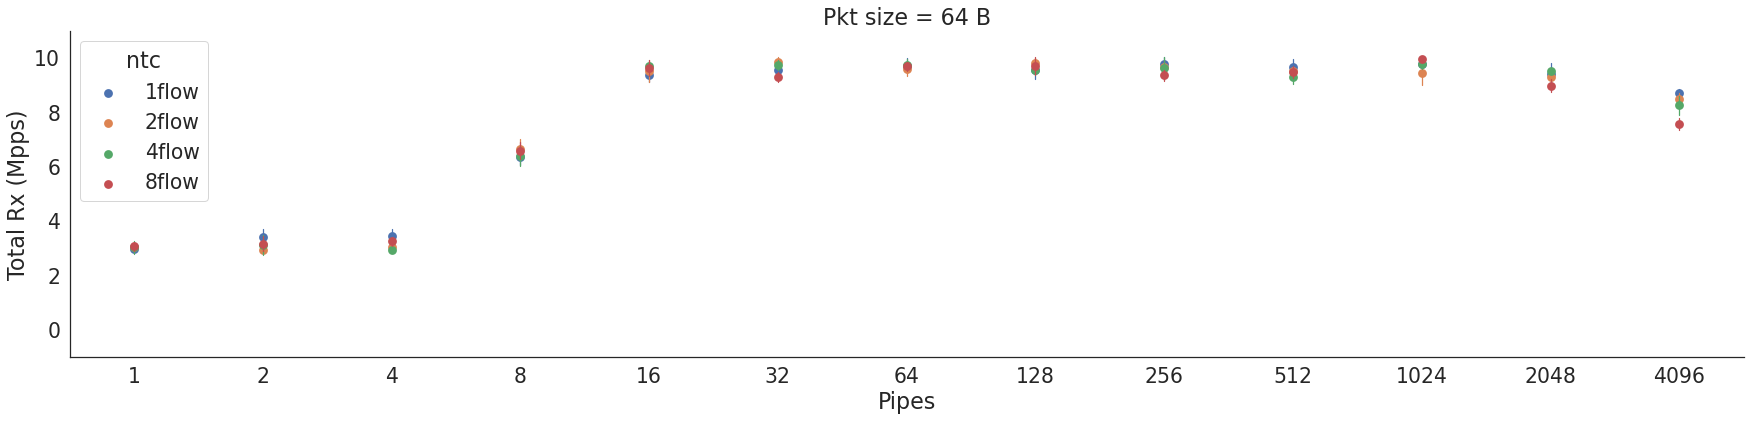

In [5]:
# %#matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[5 * FIGSIZE[0], FIGSIZE[1]])

p_df = hqosmax_df
p_df = p_df.astype({"flows": int})

# ax1.set_xscale('symlog')

fig = sns.pointplot(
    data=p_df[p_df["packet_size"] == 64],
    x="flows",
    y=hqosmax_df["total_rx_pps"] / (10**6),
    hue = 'ntc',
    # y=multicore_measures_df["total_rx_L1"] / (10**9),
    # units="units",
    # estimator = pd.mean,
    # ax=ax1,
    # palette="colorblind",
    ci="sd",
    err_style="bars",
    # markersize=1,
    # errorwidth=3,
    join=False,
    linestyle="--",
    # linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Pipes",
    title="Pkt size = 64 B",
    ylim=[-1, 11],
)
plt.setp(fig.lines, linewidth=1.25)
sns.despine()

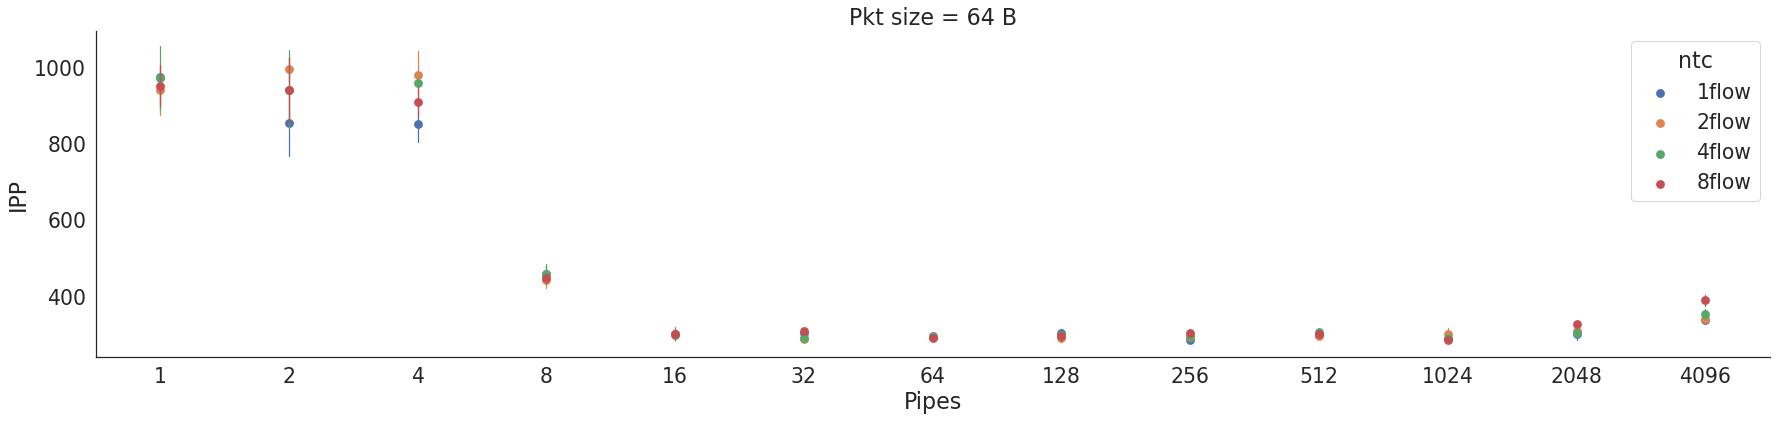

In [40]:
# %#matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[5 * FIGSIZE[0], FIGSIZE[1]])

p_df = hqosmax_df
p_df = p_df.astype({"flows": int})

# ax1.set_xscale('symlog')

fig = sns.pointplot(
    data=p_df[p_df["packet_size"] == 64],
    x="flows",
    y=((2.2*10**9)/ p_df["total_rx_pps"])*p_df["IPC"],
    hue = 'ntc',
    # y=multicore_measures_df["total_rx_L1"] / (10**9),
    # units="units",
    # estimator = pd.mean,
    # ax=ax1,
    # palette="colorblind",
    ci="sd",
    err_style="bars",
    # markersize=1,
    # errorwidth=3,
    join=False,
    linestyle="--",
    # linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="IPP",
    xlabel="Pipes",
    title="Pkt size = 64 B",
    #lim=[-1, 11],
)
plt.setp(fig.lines, linewidth=1.25)
sns.despine()

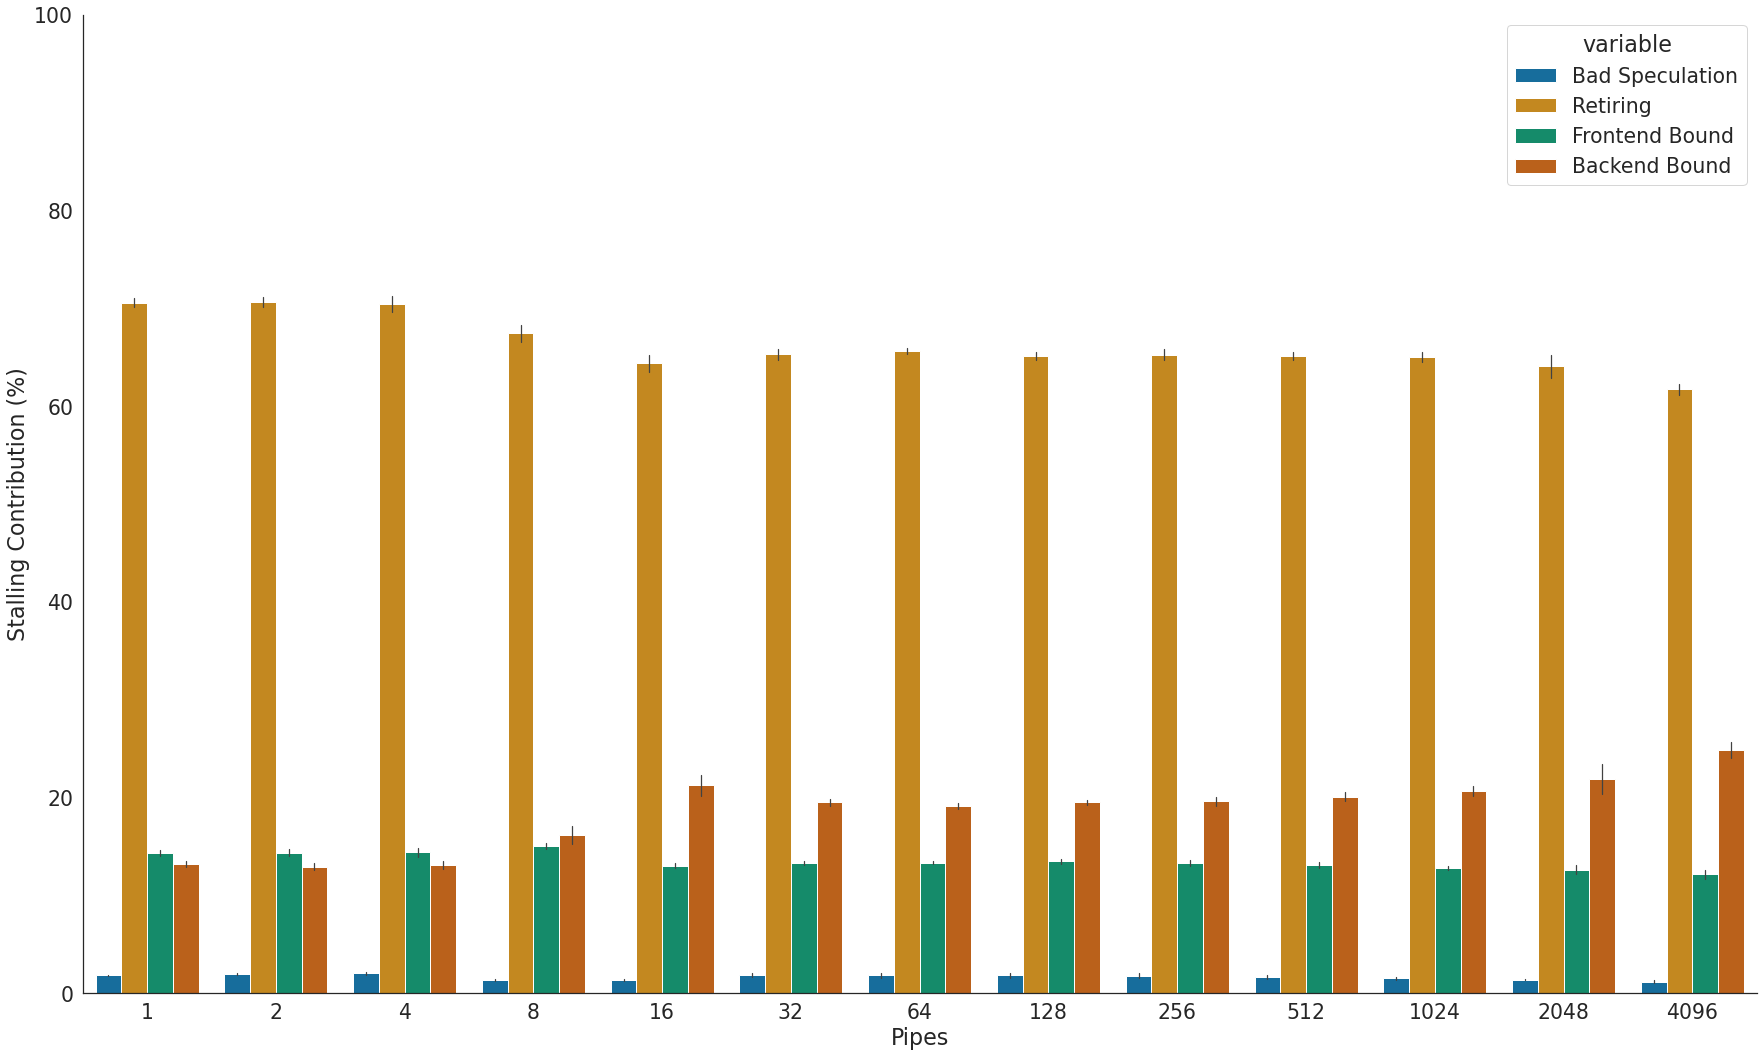

In [6]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    hqosmax_df,
    id_vars = ['flows', 'units'],
    value_vars = ['Bad Speculation', 'Retiring', 'Frontend Bound', 'Backend Bound']
)

#ax1.set_xscale('symlog')
fig = sns.barplot(
    data=p_df,
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Stalling Contribution (%)",
    xlabel="Pipes",
   # title="Misses\nPkt size = 64 B",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

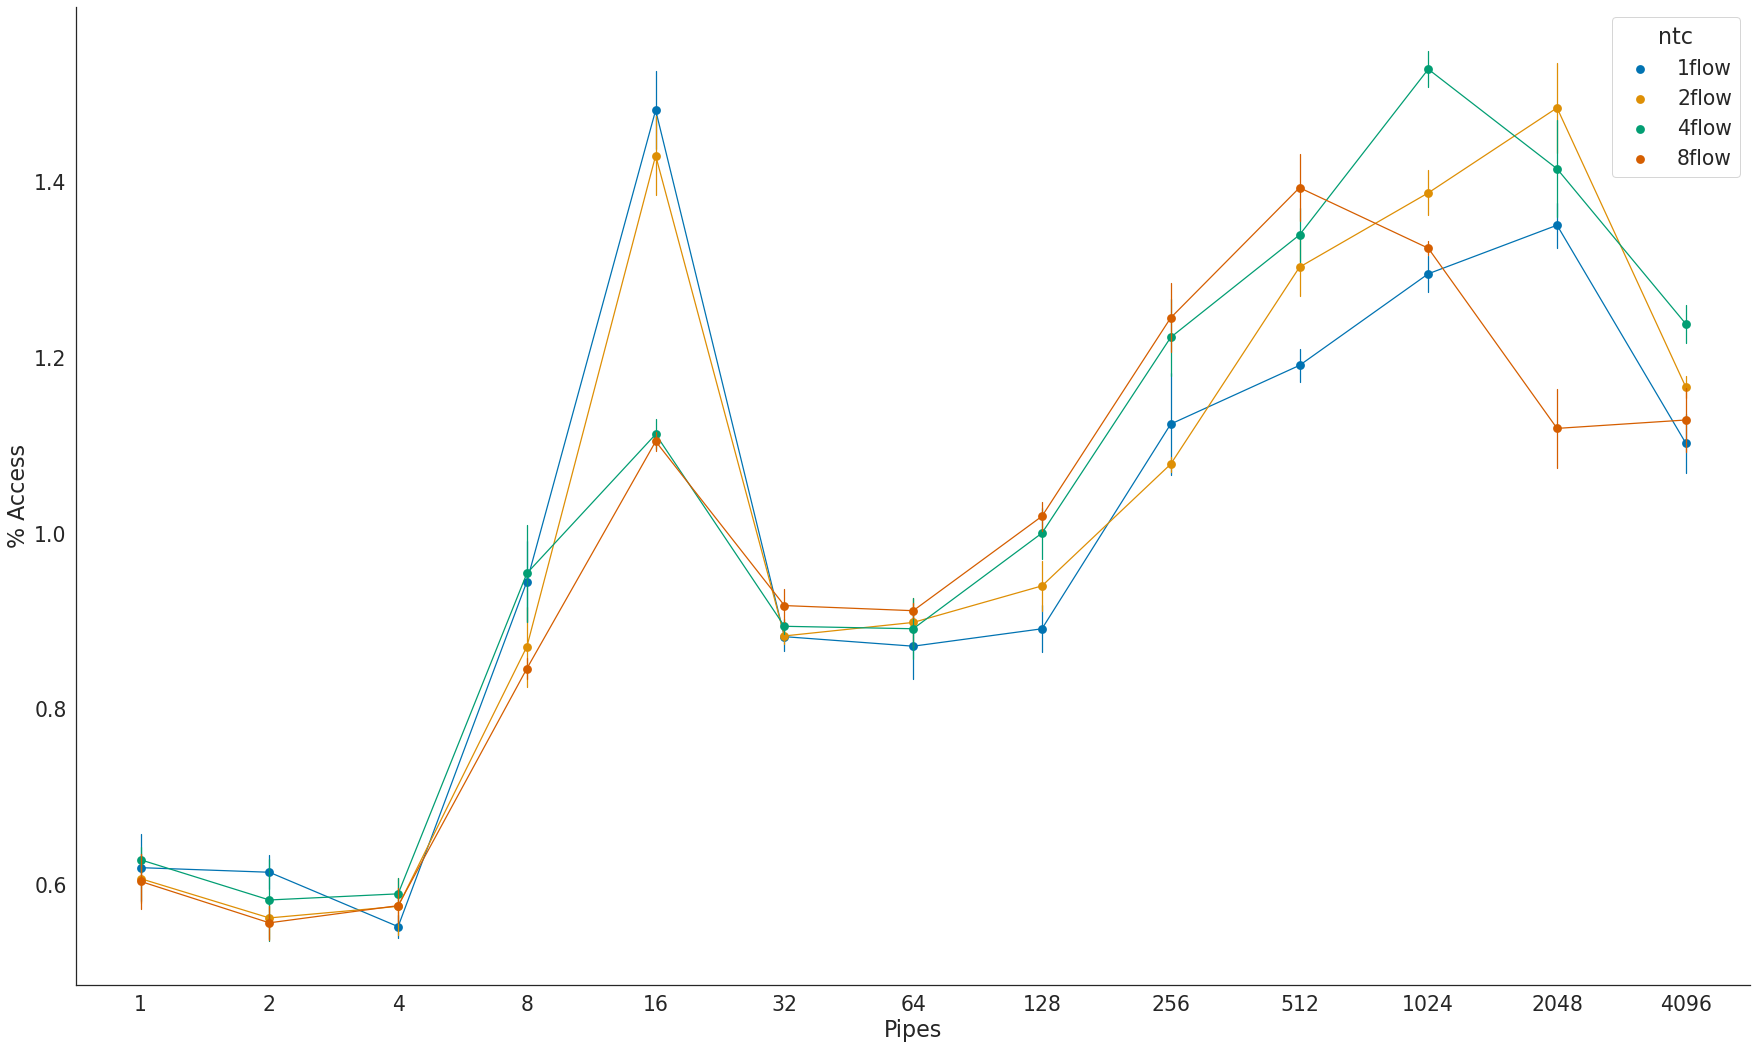

In [12]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    hqosmax_df,
    id_vars = ['flows', 'units', 'ntc'],
    # value_vars = ['L1 Bound','L2 Bound','L3 Bound','Memory Bound']
    value_vars = ['L3 Bound']
)

#ax1.set_xscale('symlog')
fig = sns.pointplot(
    data=p_df,
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="ntc",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=True,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="% Access",
    xlabel="Pipes",
   # title="Misses\nPkt size = 64 B",
   # ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

In [92]:
p_df

,flows,units,ntc,variable,value
0,1024,3,1flow,L3 Bound,1.266901
1,1024,1,1flow,L3 Bound,1.312530
2,1024,2,1flow,L3 Bound,1.306536
3,4,3,1flow,L3 Bound,0.568783
4,4,1,1flow,L3 Bound,0.537959
...,...,...,...,...,...
307,64,1,8flow,Memory Bound,0.232676
308,64,2,8flow,Memory Bound,0.228872
309,2,3,8flow,Memory Bound,0.118954
310,2,1,8flow,Memory Bound,0.128728


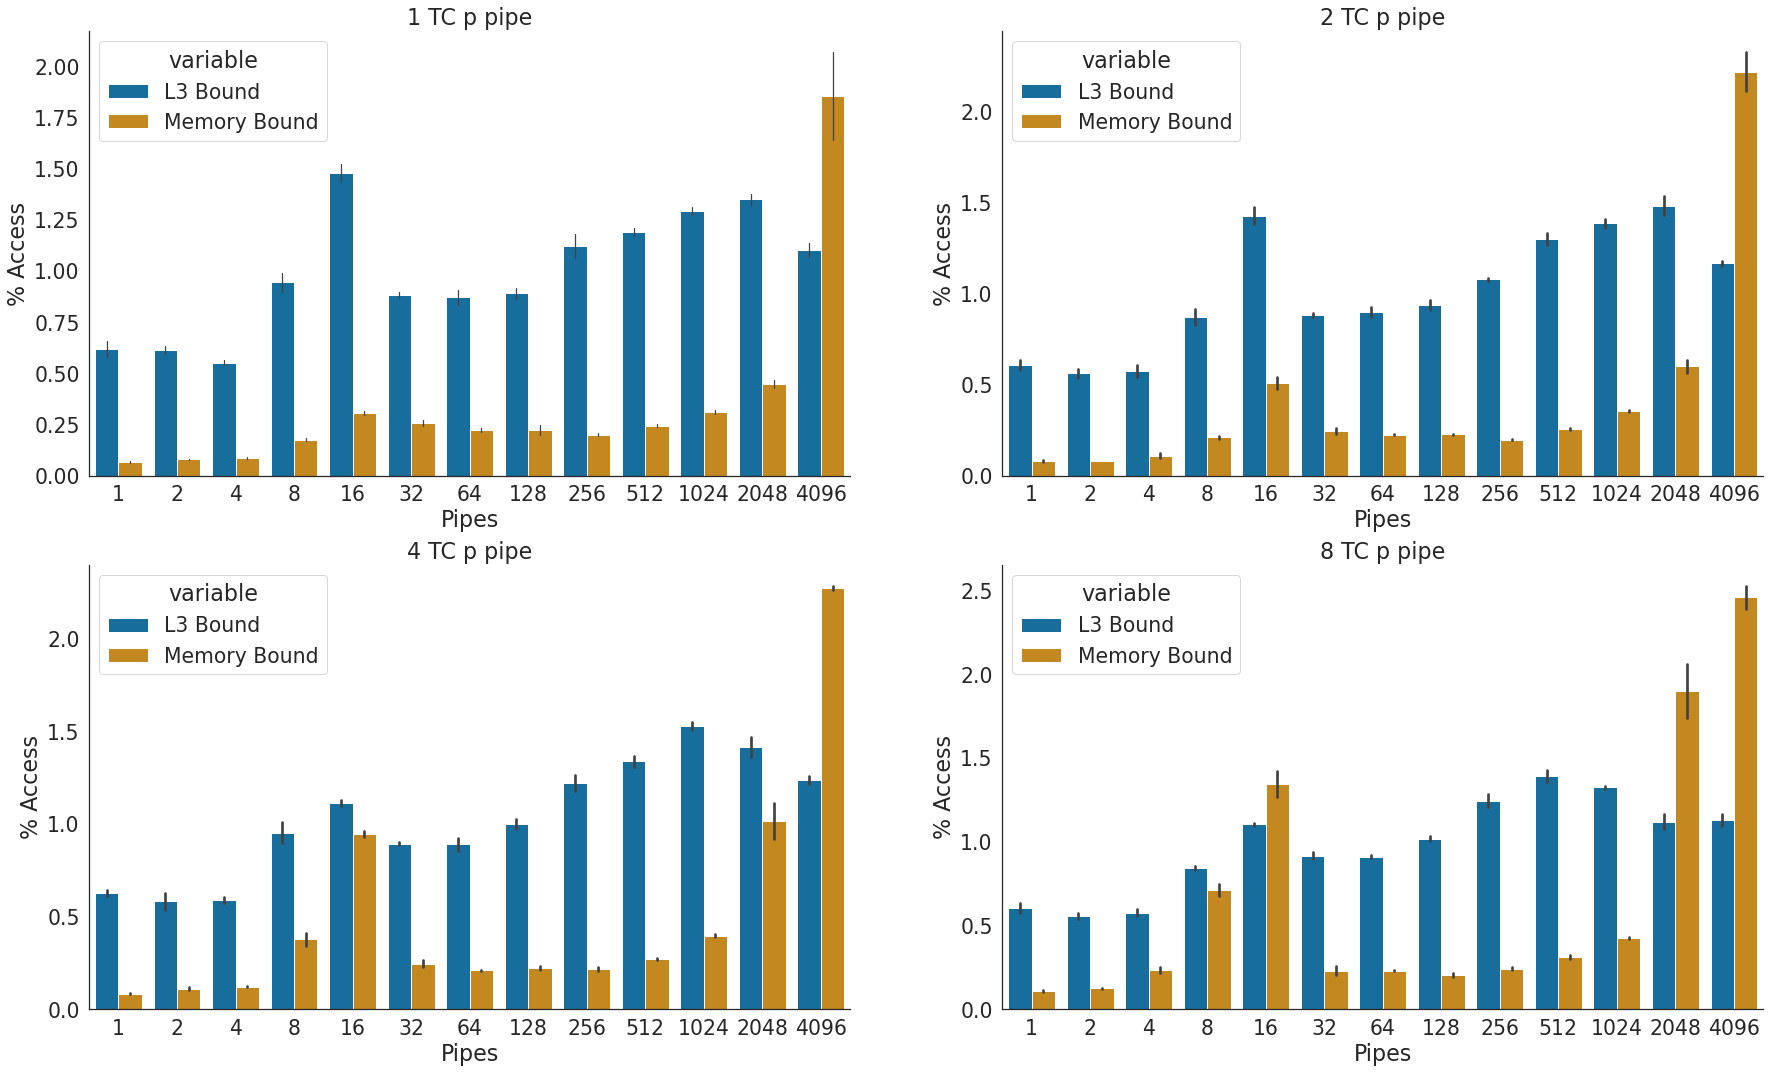

In [94]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    hqosmax_df,
    id_vars = ['flows', 'units', 'ntc'],
    value_vars = ['L3 Bound','Memory Bound']
)

#ax1.set_xscale('symlog')
fig = sns.barplot(
    data=p_df[p_df['ntc'] == '1flow'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="1 TC p pipe",
    #ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig2 = sns.barplot(
    data=p_df[p_df['ntc'] == '2flow'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax2,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="2 TC p pipe",
    #ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig3 = sns.barplot(
    data=p_df[p_df['ntc'] == '4flow'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax3,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="4 TC p pipe",
   # ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)


#ax1.set_xscale('symlog')
fig4 = sns.barplot(
    data=p_df[p_df['ntc'] == '8flow'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax4,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax4.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="8 TC p pipe",
    #ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

### HQoS @ 6.1 Mbps

In [18]:
measurements = list()
experiment_list = [
    "1flows-shaper",
    "2flow-shaper", 
    "4flows-shaper", 
    "8flows-shaper", 
]

for experiment in experiment_list:
    output_dir = f"../output/6.1-{experiment}"
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        call = 0
        loops_p_worker = 0

        for file in files:
            none, flows, packet_size, repeat = direc.replace(output_dir, "").split("/")

            if "average" in file:
                perfstat = pd.read_csv(direc + "/" + file, index_col = 'metrics')

            if "vpp" in file:
                with open(
                    direc + "/" + file, "r", encoding="utf8", errors="ignore"
                ) as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])
                            continue

                        m = re.search(r"\[0 @ 2\]: (\d*) packets \/err\/dev1-tx\/Tx packet drops.*", line)
                        if (m):
                            drops += int(m.group(1))
                            continue

                        if (
                            "/sys/vector_rate_per_worker" in line
                            and "0]:" in p[2]
                            and "[2" in p[0]

                        ):
                            vectors = int(p[3])
                            continue

                        if (
                            " /sys/loops_per_worker" in line
                            and "0]:" in p[2]
                            and "[2" in p[0]
                        ):
                            loops_p_worker = int(p[3])
                            continue

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = ast.literal_eval(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue


        metric = 'max'
        total_errors = misses + drops
        pkt_loss = t["total"]["opackets"] - t["total"]["ipackets"]

        measurements.append(
            {
                "total_rx_L1": t["total"]["rx_bps_L1"],
                "total_tx_L1": int(t["total"]["tx_bps_L1"]),
                "total_tx_pps": int(t["total"]["tx_pps"]),
                "total_rx_pps": int(t["total"]["rx_pps"]),
                "lost_packets": pkt_loss,

                #"VNF": label,
                #'ST': 'SMT' if 'ht' in experiment else 'ST',
                'ntc': experiment.strip('flow-shaper'),
                "packet_size": int(packet_size),
                "misses": misses,
                'flows': int(flows),
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                #"no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,
                "loops": loops_p_worker,

                'IPC': perfstat.loc['metric_IPC', metric],
                'CPI': perfstat.loc['metric_CPI', metric],
                'Frontend Bound': perfstat.loc['metric_TMA_Frontend_Bound(%)',metric],
                'Backend Bound': perfstat.loc['metric_TMA_Backend_Bound(%)', metric],
                'Memory Bound': perfstat.loc['metric_TMA_..Memory_Bound(%)', metric],
                'Core Bound': perfstat.loc['metric_TMA_..Core_Bound(%)', metric],
                'External Memory Bound': perfstat.loc['metric_TMA_....MEM_Bound(%)', metric],
                'DTLB load miss': perfstat.loc['metric_DTLB load miss latency (in core clks)', metric],
                'Bad Speculation': perfstat.loc['metric_TMA_Bad_Speculation(%)', metric],
                'Retiring': perfstat.loc['metric_TMA_Retiring(%)', metric],

                'Ports Utilization': perfstat.loc['metric_TMA_......Ports_Utilized_3m(%)', metric],

                'L1 Bound': perfstat.loc['metric_TMA_....L1_Bound(%)', metric],
                'L2 Bound': perfstat.loc['metric_TMA_....L2_Bound(%)', metric],
                'L3 Bound': perfstat.loc['metric_TMA_....L3_Bound(%)',metric],

              #"vector_rate": vector_rate,
            }
        )
        shape_61_df = pd.DataFrame(measurements)

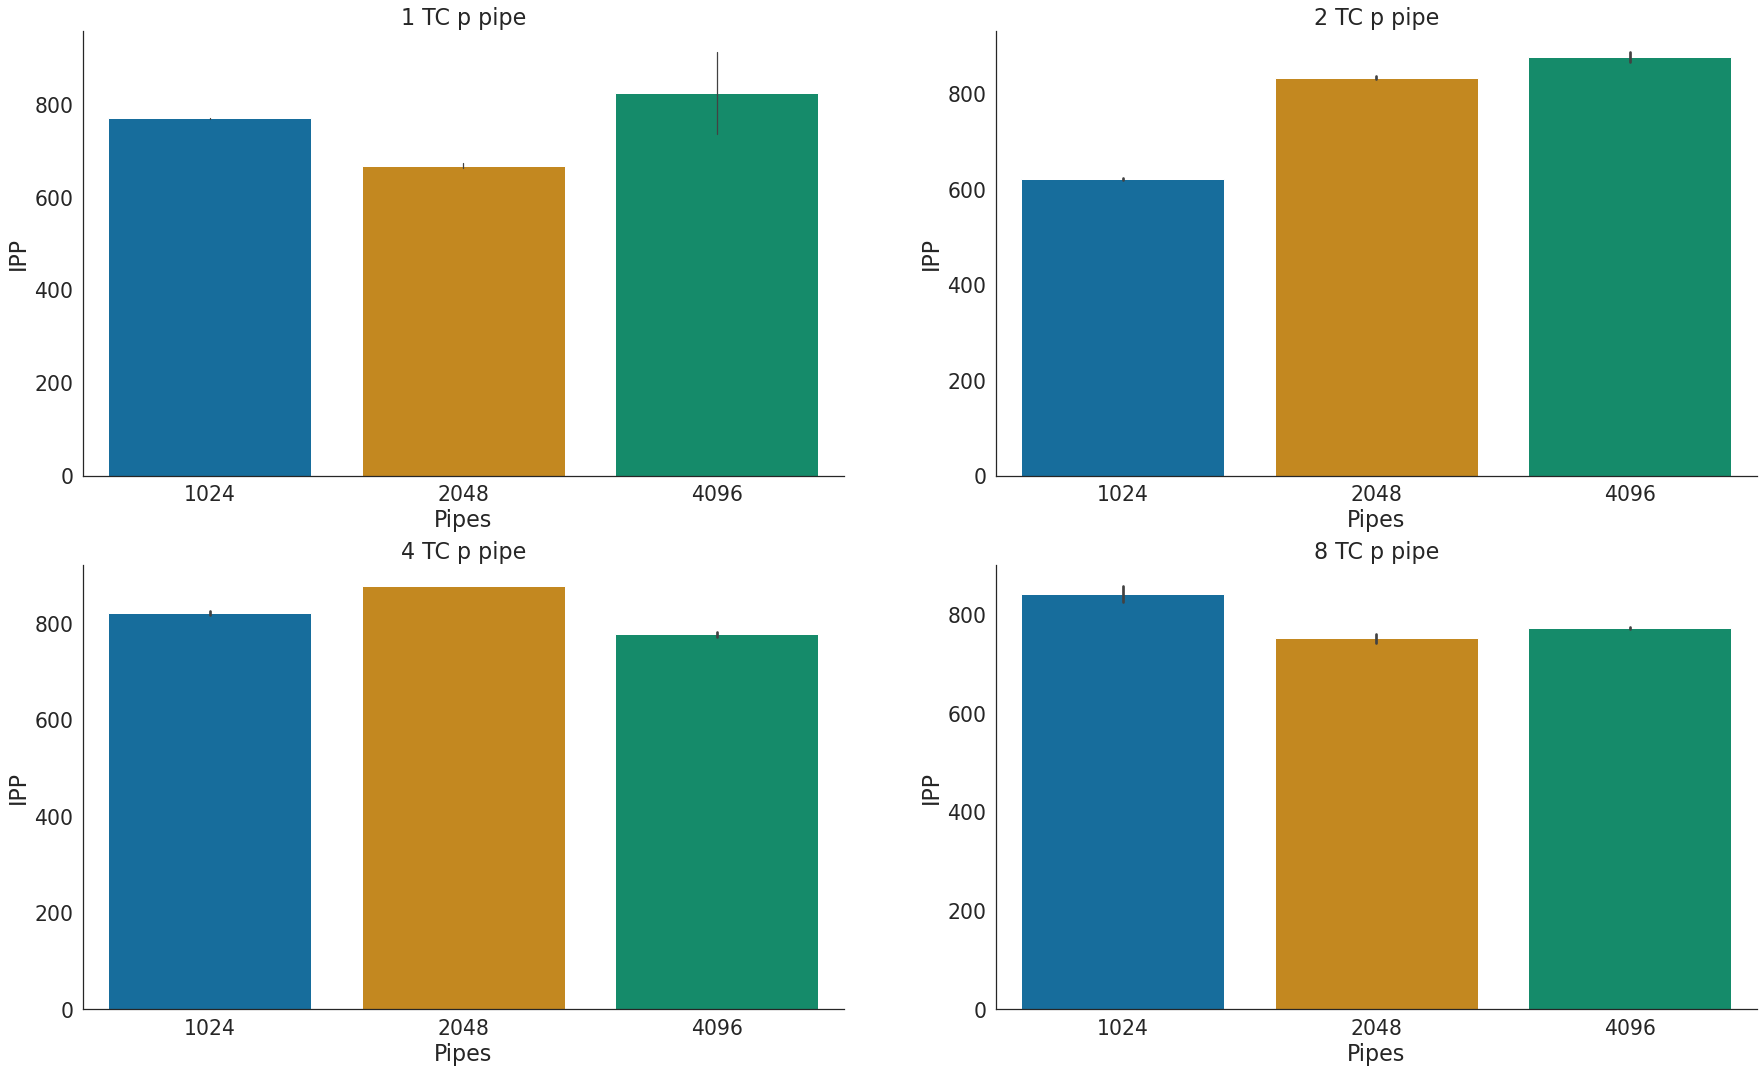

In [41]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = shape_61_df[shape_61_df['ntc'] == '1']
fig = sns.barplot(
    data=p_df[p_df['flows'] > 512],
    x="flows",
    y=((2.2*10**9)/ p_df["total_rx_pps"])*p_df["IPC"],
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    # hue="variable",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="IPP",
    xlabel="Pipes",
    title="1 TC p pipe",
   # ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

p_df = shape_61_df[shape_61_df['ntc'] == '2']
#ax1.set_xscale('symlog')
fig2 = sns.barplot(
    data=p_df[p_df['flows'] > 512],
    x="flows",
    y=((2.2*10**9)/ p_df["total_rx_pps"])*p_df["IPC"],
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    # hue="variable",
    units="units",
    #estimator = None,
    ax=ax2,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="IPP",
    xlabel="Pipes",
    title="2 TC p pipe",
    #ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

p_df = shape_61_df[shape_61_df['ntc'] == '4']
#ax1.set_xscale('symlog')
fig3 = sns.barplot(
    data=p_df[p_df['flows'] > 512],
    x="flows",
    y=((2.2*10**9)/ p_df["total_rx_pps"])*p_df["IPC"],
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    #hue="variable",
    units="units",
    #estimator = None,
    ax=ax3,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel="IPP",
    xlabel="Pipes",
    title="4 TC p pipe",
    #ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

p_df = shape_61_df[shape_61_df['ntc'] == '8']
#ax1.set_xscale('symlog')
fig4 = sns.barplot(
    data=p_df[p_df['flows'] > 512],
    x="flows",
    y=((2.2*10**9)/ p_df["total_rx_pps"])*p_df["IPC"],
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
   # hue="variable",
    units="units",
    #estimator = None,
    ax=ax4,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax4.set(
    ylabel="IPP",
    xlabel="Pipes",
    title="8 TC p pipe",
    #ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

In [ ]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    shape_61_df,
    id_vars = ['flows', 'units', 'ntc'],
    value_vars = ['Bad Speculation', 'Frontend Bound', 'Backend Bound']
)

#ax1.set_xscale('symlog')
fig = sns.barplot(
    data=p_df[p_df['ntc'] == '1'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="1 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig2 = sns.barplot(
    data=p_df[p_df['ntc'] == '2'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax2,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="2 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig3 = sns.barplot(
    data=p_df[p_df['ntc'] == '4'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax3,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="4 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


#ax1.set_xscale('symlog')
fig4 = sns.barplot(
    data=p_df[p_df['ntc'] == '8'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax4,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax4.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="8 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

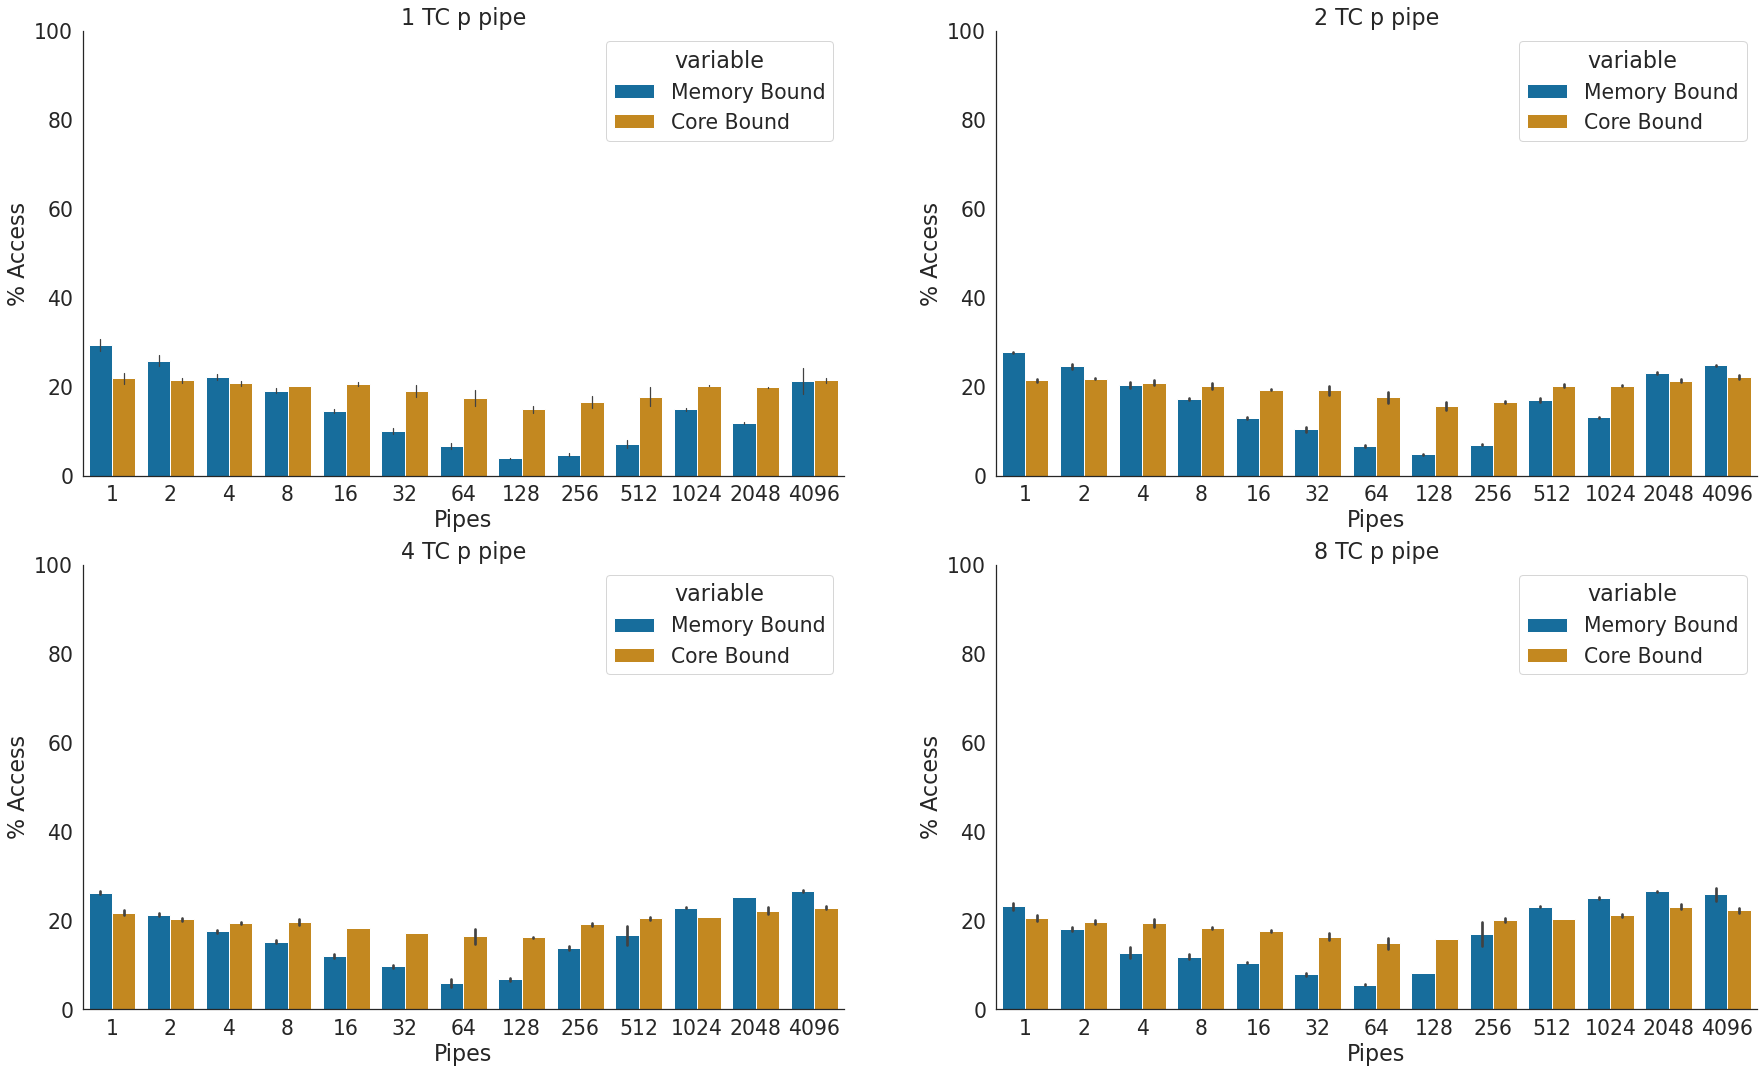

In [80]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    shape_61_df,
    id_vars = ['flows', 'units', 'ntc'],
    value_vars = ['Memory Bound', 'Core Bound']
)

#ax1.set_xscale('symlog')
fig = sns.barplot(
    data=p_df[p_df['ntc'] == '1'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="1 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig2 = sns.barplot(
    data=p_df[p_df['ntc'] == '2'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax2,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="2 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig3 = sns.barplot(
    data=p_df[p_df['ntc'] == '4'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax3,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="4 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


#ax1.set_xscale('symlog')
fig4 = sns.barplot(
    data=p_df[p_df['ntc'] == '8'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax4,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax4.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="8 TC p pipe",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

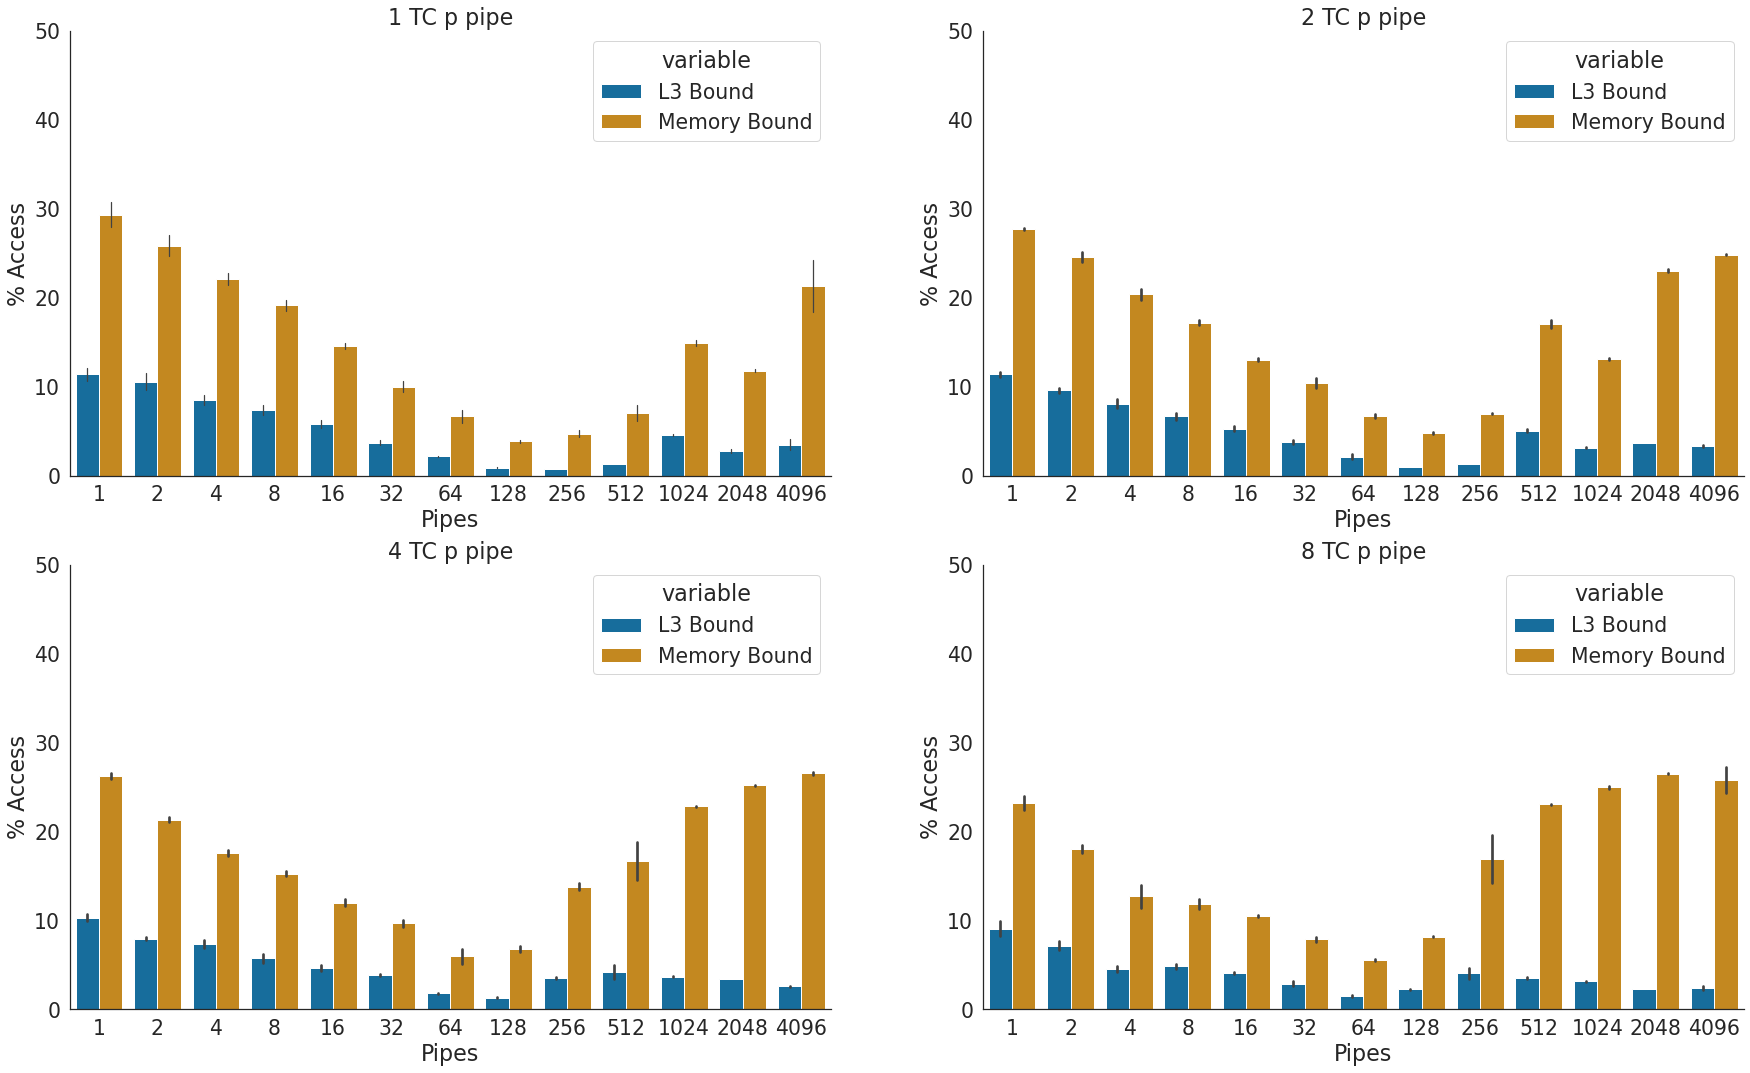

In [86]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    shape_61_df,
    id_vars = ['flows', 'units', 'ntc'],
   # value_vars = ['L1 Bound','L2 Bound','L3 Bound','Memory Bound']
     value_vars = ['L3 Bound','Memory Bound']
)

#ax1.set_xscale('symlog')
fig = sns.barplot(
    data=p_df[p_df['ntc'] == '1'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="1 TC p pipe",
    ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig2 = sns.barplot(
    data=p_df[p_df['ntc'] == '2'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax2,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="2 TC p pipe",
    ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)

#ax1.set_xscale('symlog')
fig3 = sns.barplot(
    data=p_df[p_df['ntc'] == '4'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax3,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="4 TC p pipe",
    ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)


#ax1.set_xscale('symlog')
fig4 = sns.barplot(
    data=p_df[p_df['ntc'] == '8'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax4,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax4.set(
    ylabel="% Access",
    xlabel="Pipes",
    title="8 TC p pipe",
    ylim= [0,50],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

## HQoS @ 6.1

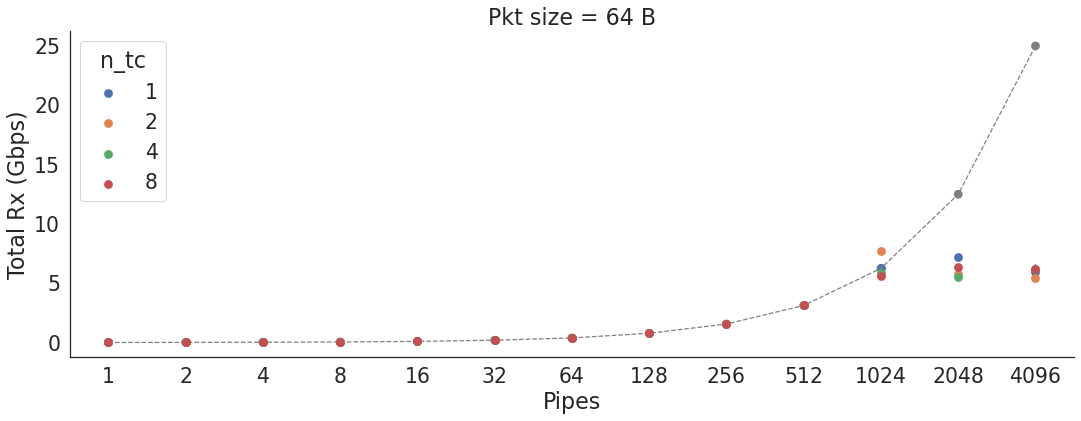

In [4]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[3*FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64

ideal_rate_df = pd.DataFrame([(i, 6.1*i) for i in set(shape_61_df['flows'])])

fig = sns.pointplot(
    data=ideal_rate_df,
    x=0,
    y = ideal_rate_df[1]/(10**3),
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    #estimator = None,
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=True,
    linestyle="--",
    linewidth=0.005,
    color = 'grey',
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)


fig = sns.pointplot(
    data=shape_61_df,
    x="flows",
    y = shape_61_df['total_rx_L1']/(10**9),
    #y=shape_61_df["total_rx_pps"] / (10**6),
    hue="n_tc",
    units="units",
    #estimator = None,
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=False,
    linestyle="--",
    linewidth=0.005,
    
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Rx (Gbps)",
    xlabel="Pipes",
    title="Pkt size = 64 B",
)
plt.setp(fig.lines, linewidth=1.25)
sns.despine()

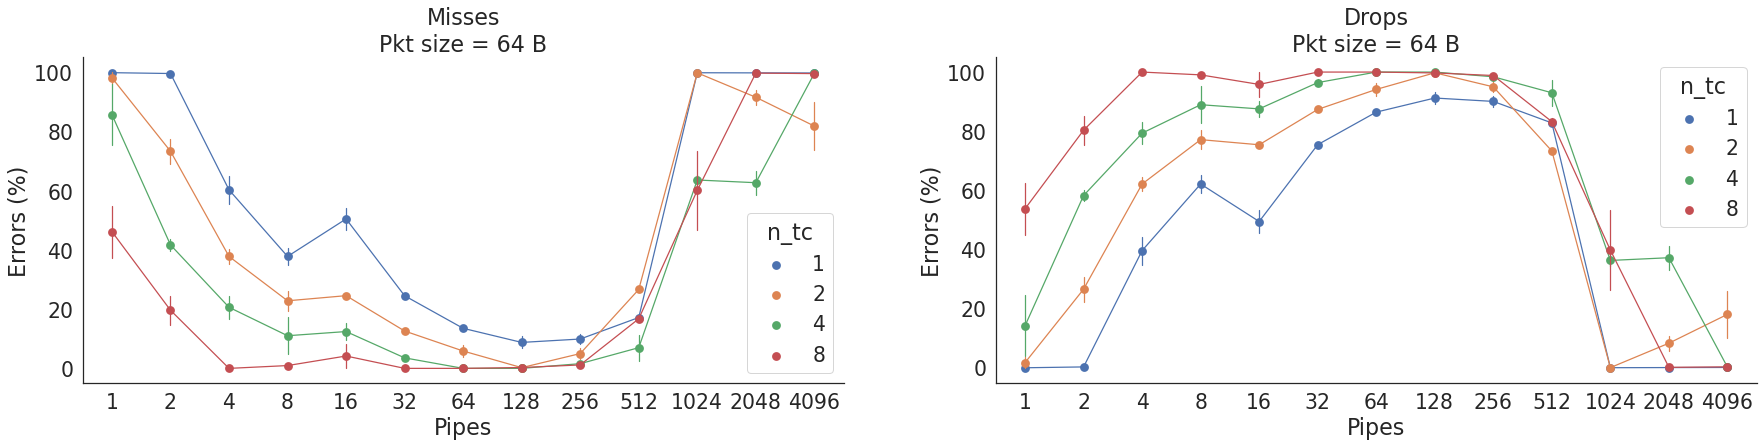

In [5]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[5*FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64

#ax1.set_xscale('symlog')

fig = sns.pointplot(
    data=shape_61_df,
    x="flows",
    y = 'misses_normalized',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="n_tc",
    units="units",
    #estimator = None,
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=True,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Errors (%)",
    xlabel="Pipes",
    title="Misses\nPkt size = 64 B",
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=shape_61_df,
    x="flows",
    y = 'drops_normalized',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="n_tc",
    units="units",
    #estimator = None,
    ax=ax2,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=True,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Errors (%)",
    xlabel="Pipes",
    title="Drops\nPkt size = 64 B",
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

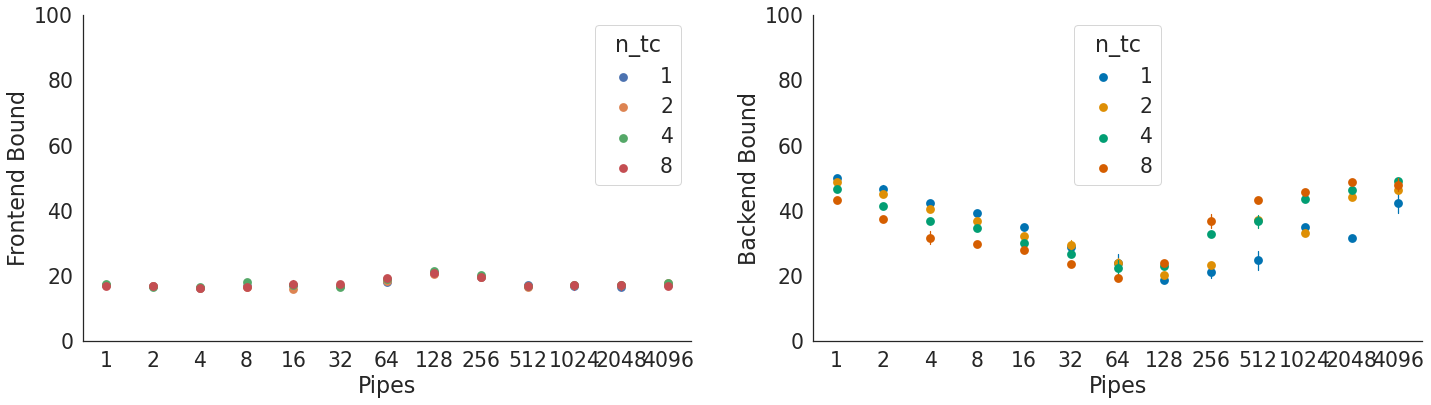

In [7]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[4*FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64

#ax1.set_xscale('symlog')

fig = sns.pointplot(
    data=shape_61_df,
    x="flows",
    y = 'Frontend Bound',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="n_tc",
    units="units",
    #estimator = None,
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=False,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
   # ylabel="Total Rx (Mpps)",
    xlabel="Pipes",
   # title="Misses\nPkt size = 64 B",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=shape_61_df,
    x="flows",
    y = 'Backend Bound',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="n_tc",
    units="units",
    #estimator = None,
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=False,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    #ylabel="Total Rx (Mpps)",
    xlabel="Pipes",
    #title="Drops\nPkt size = 64 B",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

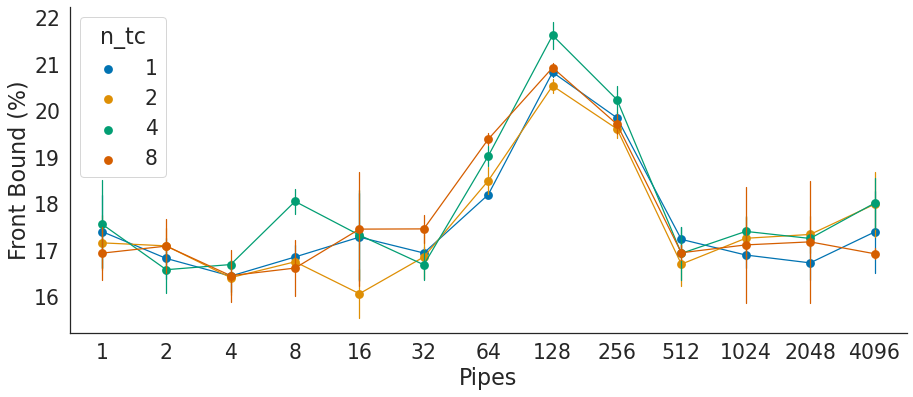

In [10]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[2.5*FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64

#ax1.set_xscale('symlog')

fig = sns.pointplot(
    data=shape_61_df,
    x="flows",
    y = 'Frontend Bound',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="n_tc",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=True,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Front Bound (%)",
    xlabel="Pipes",
    #title="Drops\nPkt size = 64 B",
    #ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

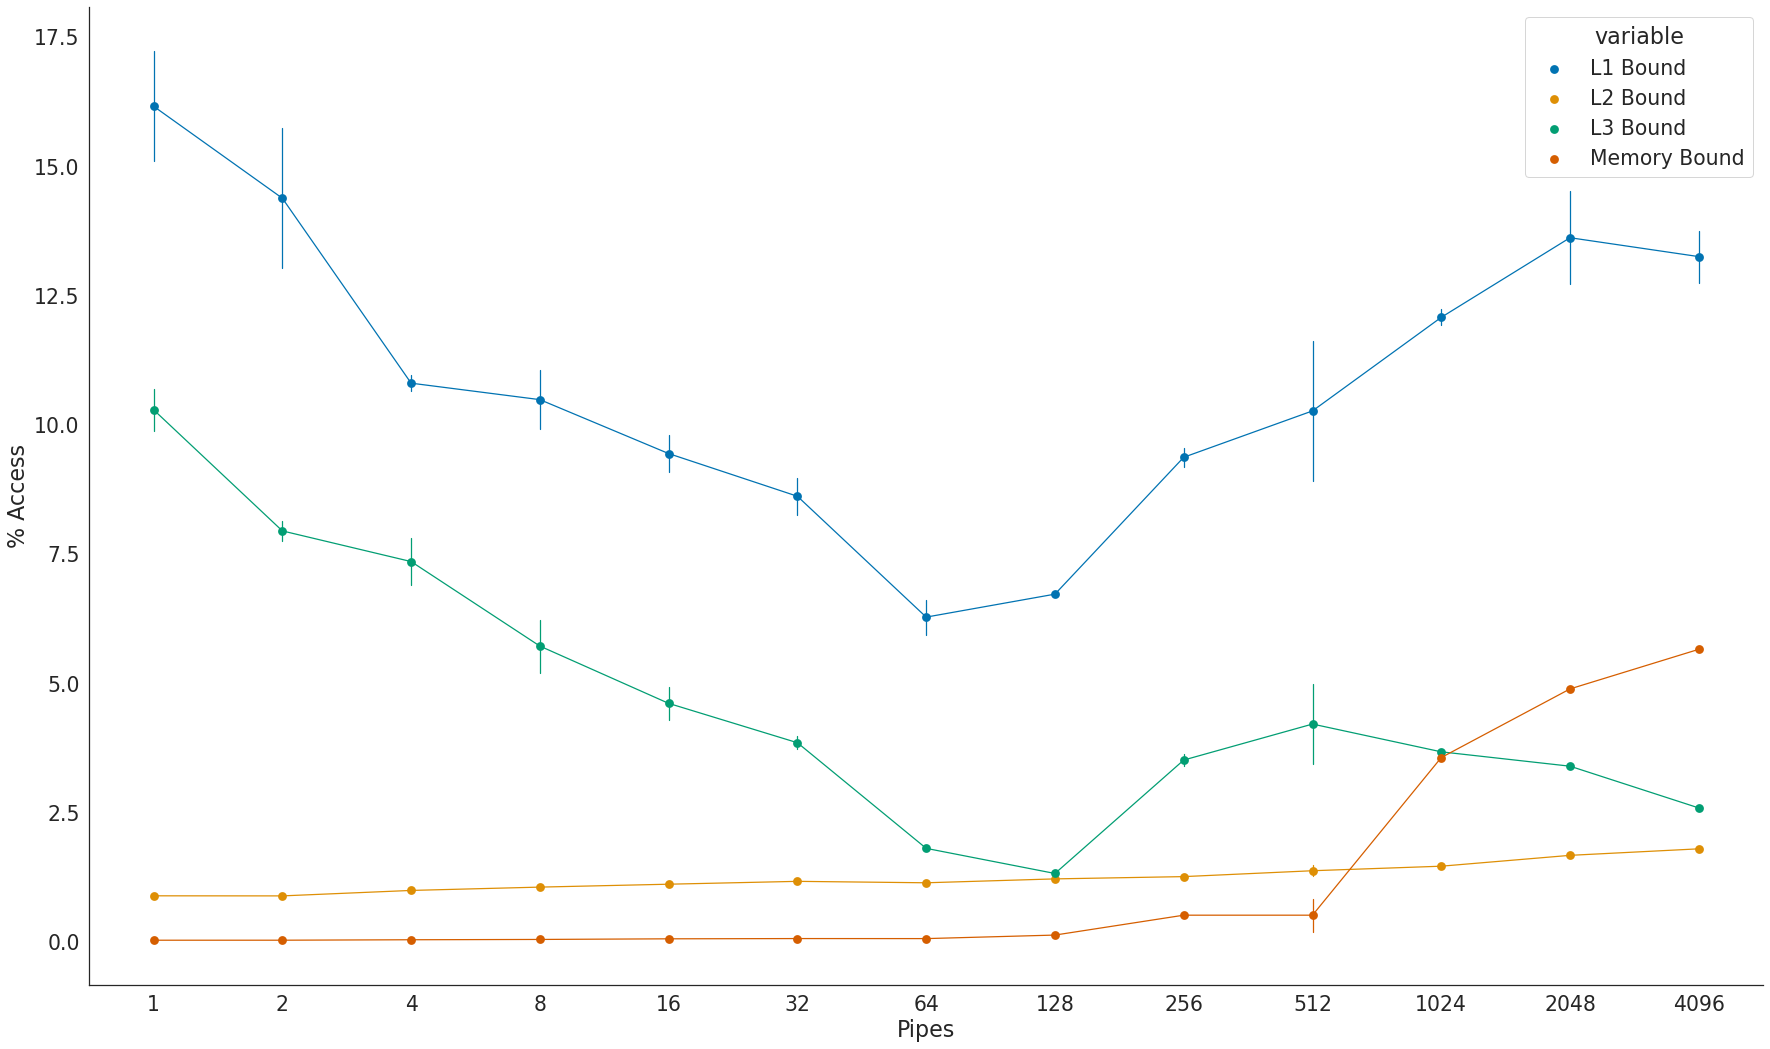

In [6]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    shape_61_df,
    id_vars = ['flows', 'units', 'n_tc'],
    value_vars = ['L1 Bound','L2 Bound','L3 Bound','Memory Bound']
)

#ax1.set_xscale('symlog')
fig = sns.pointplot(
    data=p_df[p_df['n_tc'] == '4'],
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=True,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="% Access",
    xlabel="Pipes",
   # title="Misses\nPkt size = 64 B",
   # ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

### Multithreaded HQoS

In [1]:
measurements = list()
experiment_list = [
    'l3fwd-4th-hqos-6_1mbps'
]

for experiment in experiment_list:
    output_dir = f"../output/{experiment}"
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        call = 0
        loops_p_worker = 0

        for file in files:
            none, flows, packet_size, repeat = direc.replace(output_dir, "").split("/")

            if "average" in file:
                perfstat = pd.read_csv(direc + "/" + file, index_col = 'metrics')

            if "vpp" in file:
                with open(
                    direc + "/" + file, "r", encoding="utf8", errors="ignore"
                ) as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])
                            continue

                        m = re.search(r"\[0 @ 2\]: (\d*) packets \/err\/dev1-tx\/Tx packet drops.*", line)
                        if (m):
                            drops += int(m.group(1))
                            continue

                        if (
                            "/sys/vector_rate_per_worker" in line
                            and "0]:" in p[2]
                            and "[2" in p[0]

                        ):
                            vectors = int(p[3])
                            continue
                            
                        if "/sys/num_worker_threads" in p:
                            nworkers = float(p[0])

                        if (
                            " /sys/loops_per_worker" in line
                            and "0]:" in p[2]
                            and "[2" in p[0]
                        ):
                            loops_p_worker = int(p[3])
                            continue

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = json.loads(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue

        metric = 'p95'
        total_errors = misses + drops
       # pkt_loss = t["total"]["opackets"] - t["total"]["ipackets"]

        measurements.append(
            {
                "total_rx_L1": t["results"]["total_tx_L1"],
                "total_tx_L1": int(t["results"]["total_rx_L1"]),
                "total_tx_pps": int(t["results"]["tx_pps"]),
                "total_rx_pps": int(t["results"]["rx_pps"]),
                #"VNF": label,
                #'ST': 'SMT' if 'ht' in experiment else 'ST',
                'nworkers': nworkers,
                "packet_size": int(packet_size),
                "misses": misses,
                'flows': int(flows),
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                #"no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,

                'IPC': perfstat.loc['metric_kernel_CPI', metric],
                'Frontend Bound': perfstat.loc['metric_TMA_Frontend_Bound(%)',metric],
                'Backend Bound': perfstat.loc['metric_TMA_Backend_Bound(%)', metric],
                'Cache Bound': perfstat.loc['metric_TMA_..Memory_Bound(%)', metric],
                'Core Bound': perfstat.loc['metric_TMA_..Core_Bound(%)', metric],
                'Memory Bound': perfstat.loc['metric_TMA_....MEM_Bound(%)', metric],
                'DTLB load miss': perfstat.loc['metric_DTLB load miss latency (in core clks)', metric],
                'Bad Speculation': perfstat.loc['metric_TMA_Bad_Speculation(%)', metric],
                'Retiring': perfstat.loc['metric_TMA_Retiring(%)', metric],

                'L1 Bound': perfstat.loc['metric_TMA_....L1_Bound(%)', metric],
                'L2 Bound': perfstat.loc['metric_TMA_....L2_Bound(%)', metric],
                'L3 Bound': perfstat.loc['metric_TMA_....L3_Bound(%)',metric],

              #"vector_rate": vector_rate,
                #"call": calls,
            }
        )
        mt_df = pd.DataFrame(measurements)

NameError: name 'os' is not defined

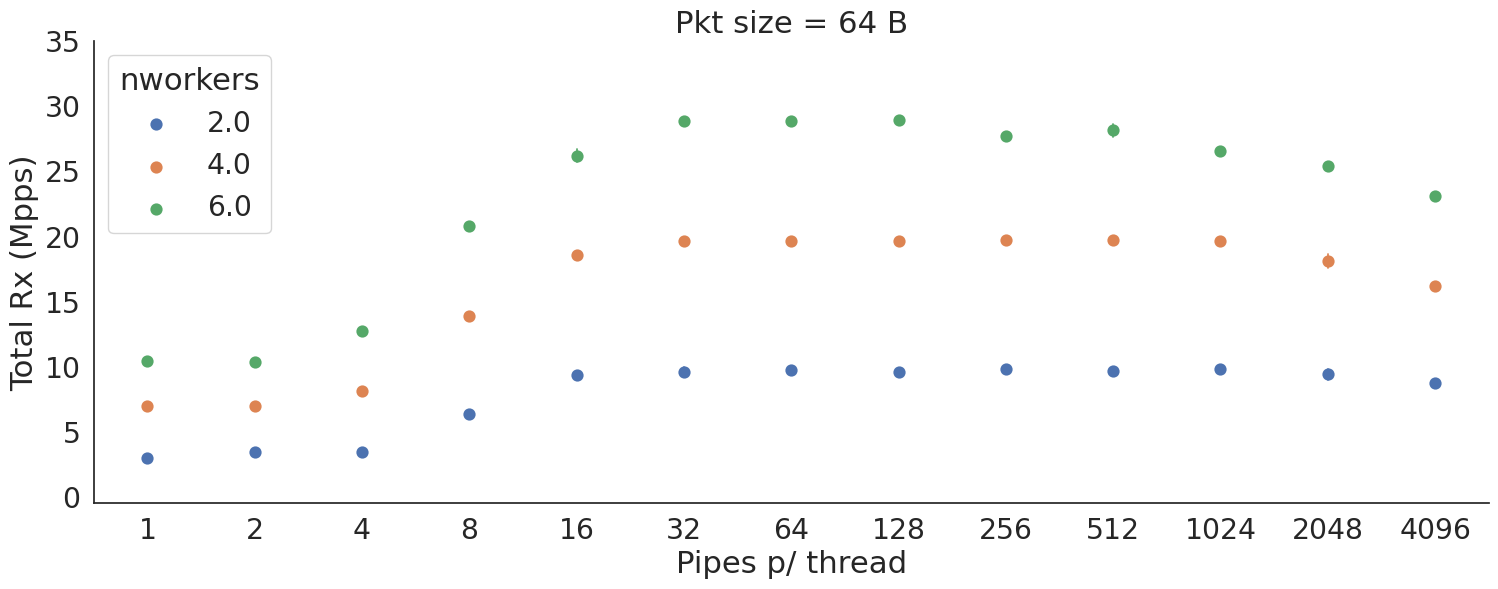

In [11]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[3*FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64

fig = sns.pointplot(
    data=mt_df,
    x="flows",
    #y = mt_df['total_rx_L1']/(10**9),
    y=mt_df["total_rx_pps"] / (10**6),
    hue="nworkers",
    units="units",
    #estimator = None,
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=False,
    linestyle="--",
    linewidth=0.005,
    
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Pipes p/ thread",
    title="Pkt size = 64 B",
    ylim = [-0.5, 35]
)
plt.setp(fig.lines, linewidth=1.25)
sns.despine()

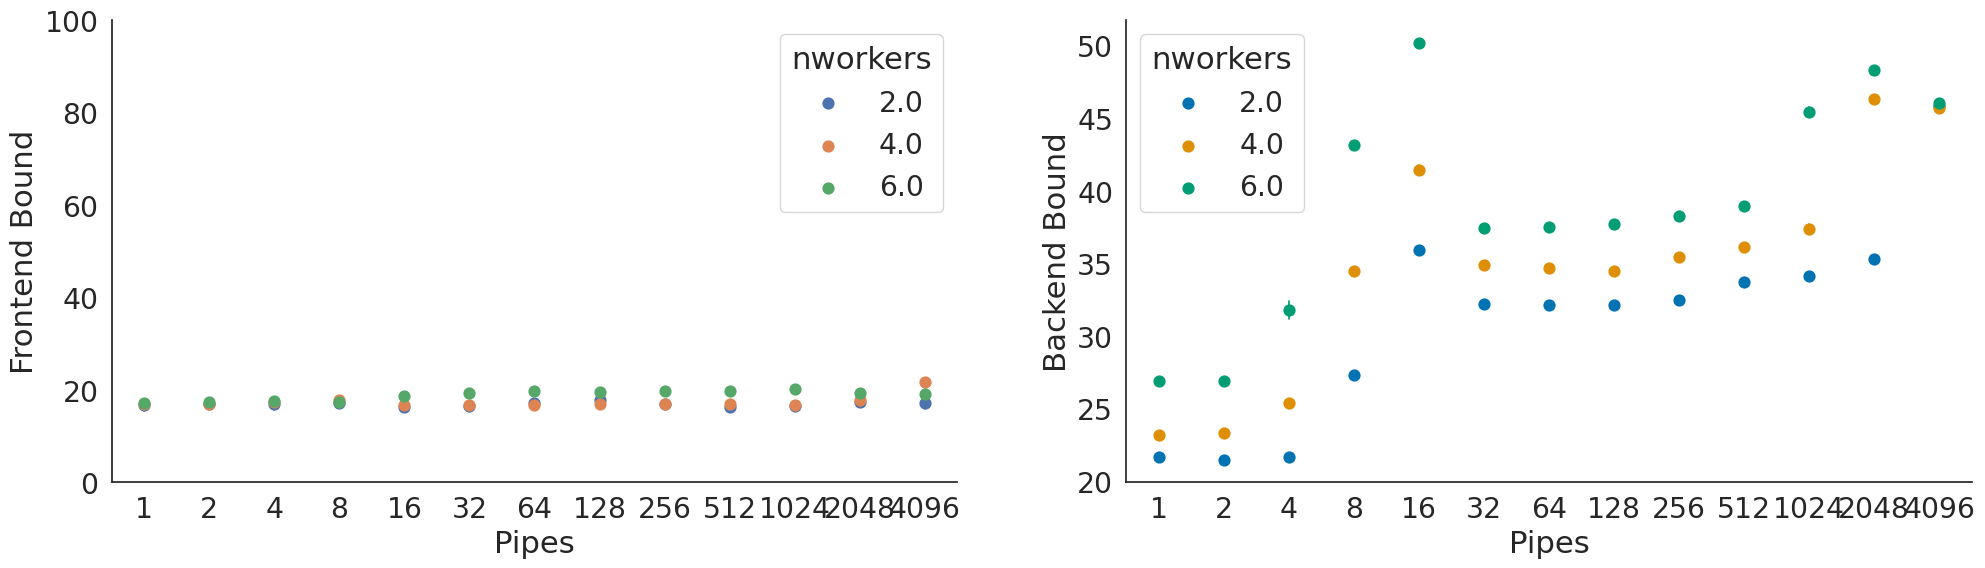

In [12]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[4*FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64

#ax1.set_xscale('symlog')

fig = sns.pointplot(
    data=mt_df,
    x="flows",
    y = 'Frontend Bound',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="nworkers",
    units="units",
    #estimator = None,
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=False,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
   # ylabel="Total Rx (Mpps)",
    xlabel="Pipes",
   # title="Misses\nPkt size = 64 B",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=mt_df,
    x="flows",
    y = 'Backend Bound',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="nworkers",
    #hue="n_tc",
    units="units",
    #estimator = None,
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=False,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    #ylabel="Total Rx (Mpps)",
    xlabel="Pipes",
    #title="Drops\nPkt size = 64 B",
    #ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

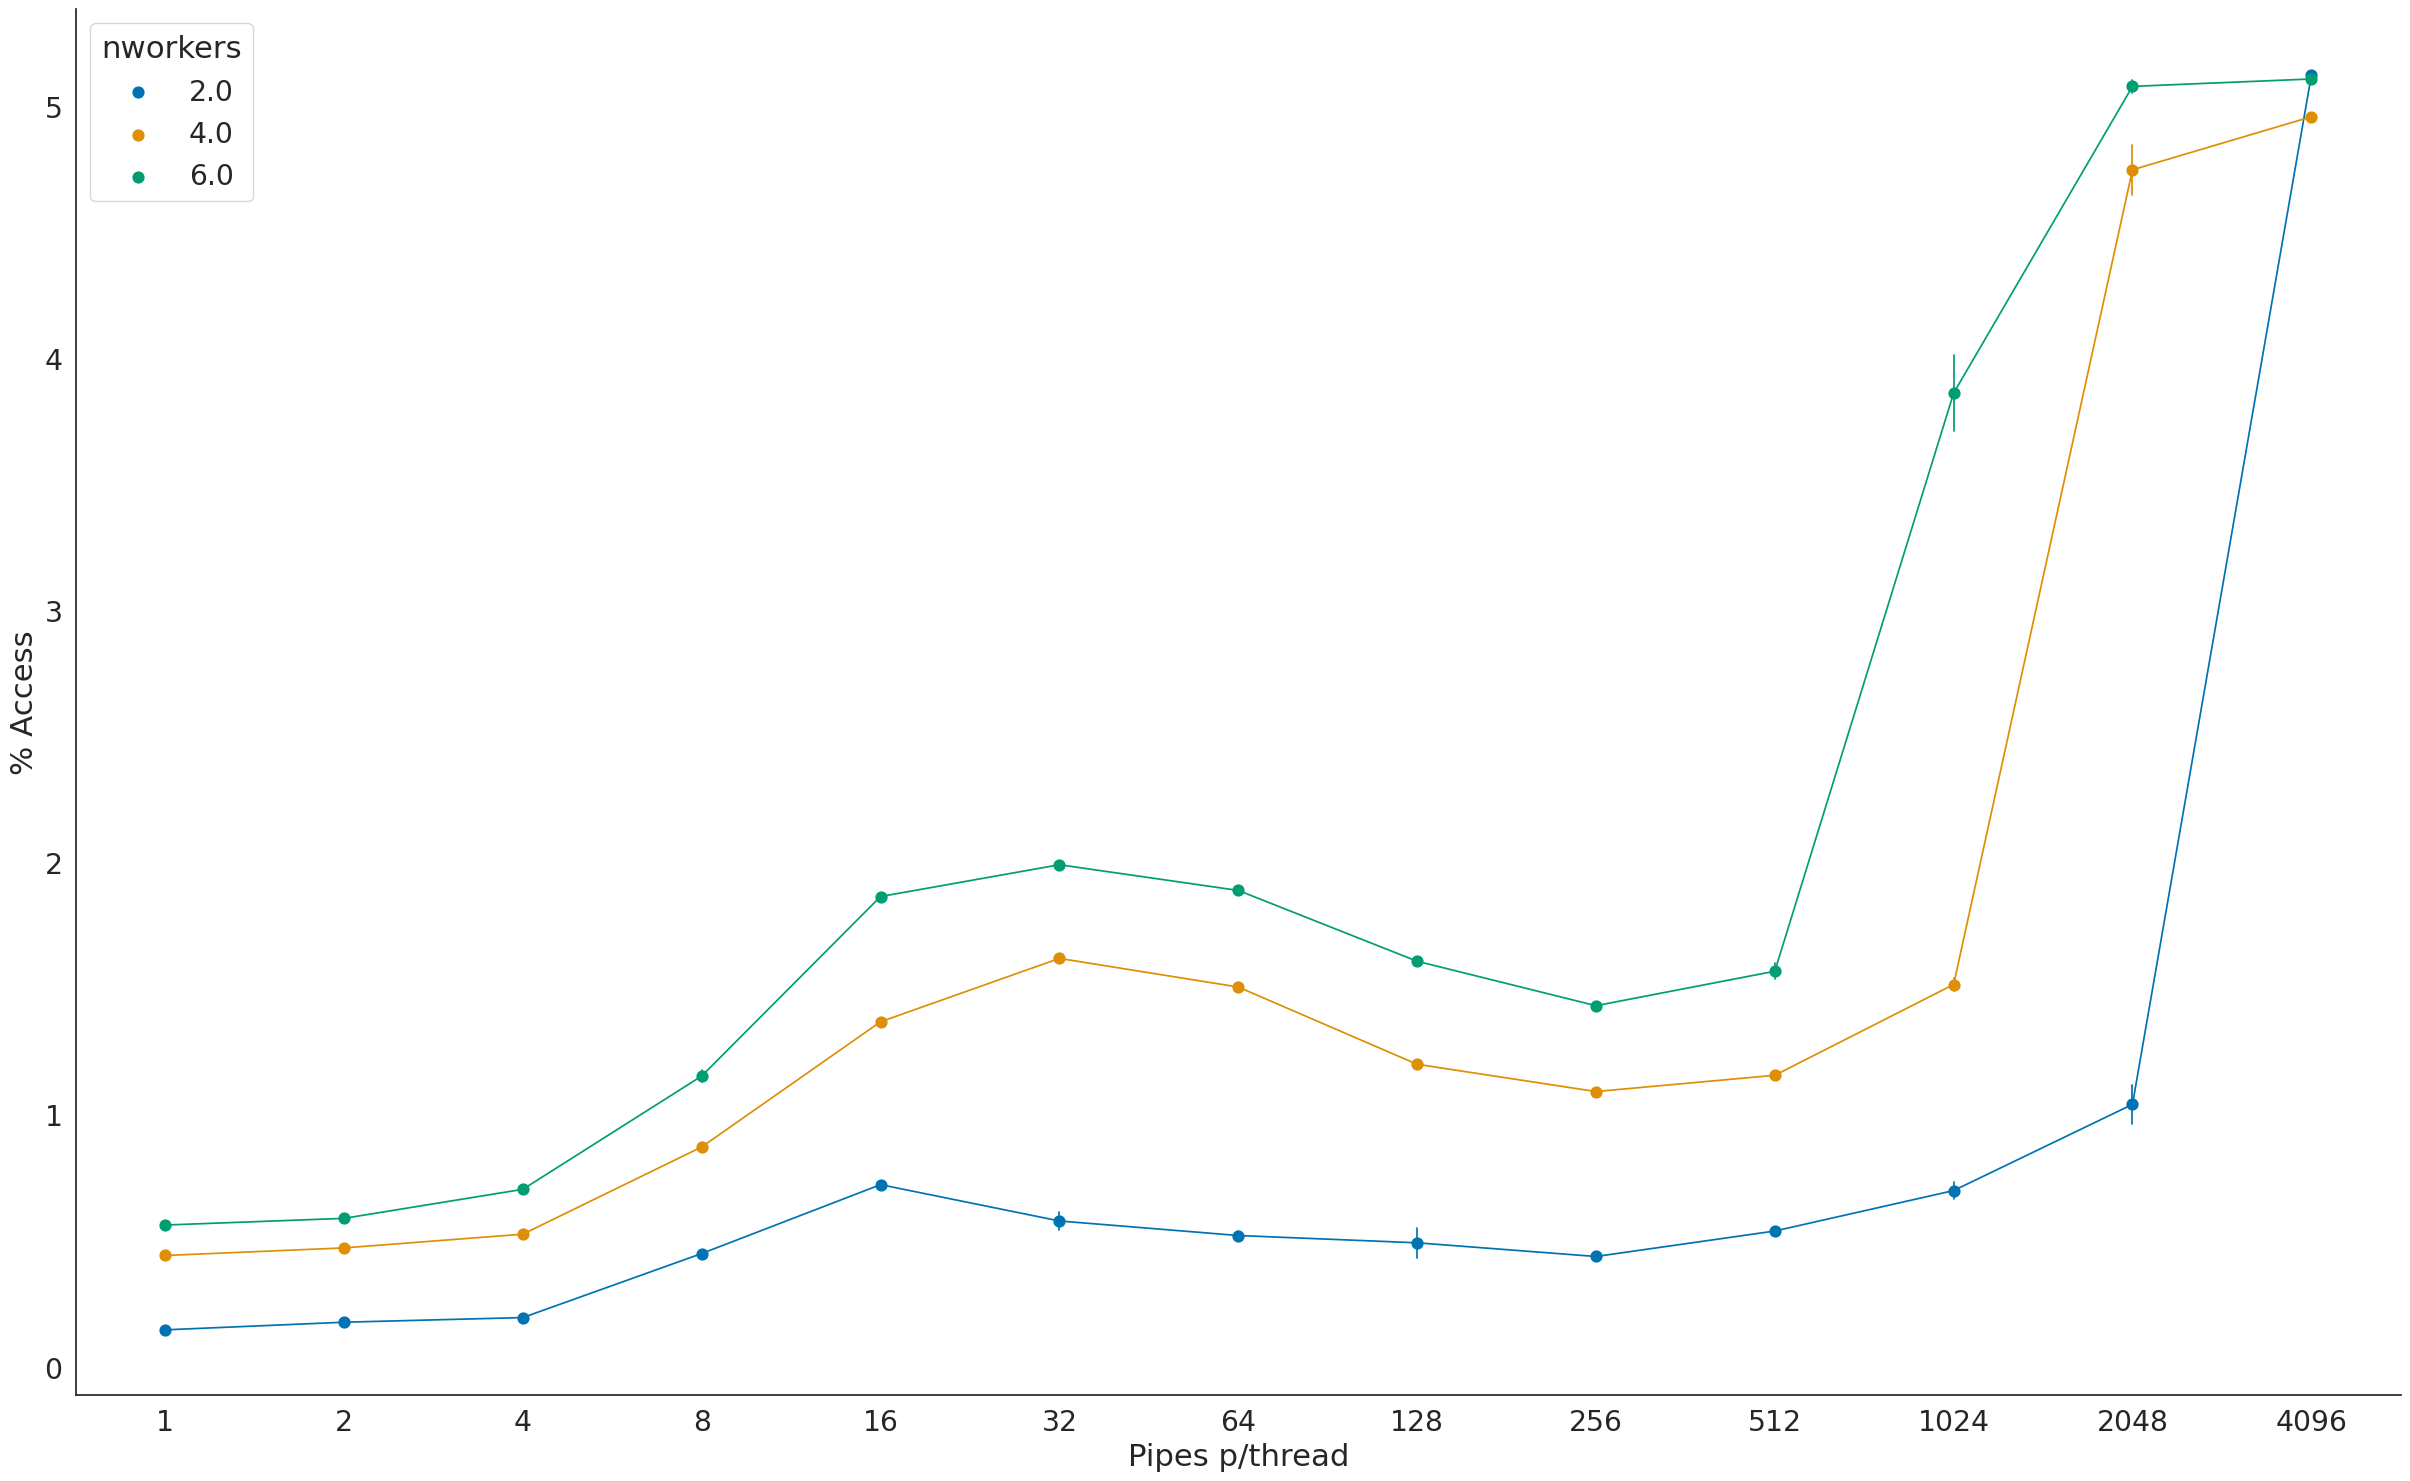

In [13]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    mt_df,
    id_vars = ['flows', 'units', 'nworkers'],
    #value_vars = ['L1 Bound','L2 Bound','L3 Bound','Memory Bound'],
    value_vars = ['Memory Bound']
)

#ax1.set_xscale('symlog')
fig = sns.pointplot(
    data=p_df,
    x="flows",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="nworkers",
    units="units",
    style = 'nworkers',
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="% Access",
    xlabel="Pipes p/thread",
   # title="Misses\nPkt size = 64 B",
   # ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

### Mbps - Multicore

In [2]:
measurements = list()
experiment_list = [
    'l3fwd-4th-hqos-6_1mbps',
]

for experiment in experiment_list:
    output_dir = f"../output/{experiment}"
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        call = 0
        loops_p_worker = 0
        nworkers = 0

        for file in files:
            none, flows, packet_size, repeat = direc.replace(output_dir, "").split("/")

            if "average" in file:
                perfstat = pd.read_csv(direc + "/" + file, index_col = 'metrics')

            if "vpp" in file:
                with open(
                    direc + "/" + file, "r", encoding="utf8", errors="ignore"
                ) as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])
                            continue

                        m = re.search(r"\[0 @ 2\]: (\d*) packets \/err\/dev1-tx\/Tx packet drops.*", line)
                        if (m):
                            drops += int(m.group(1))
                            continue

                        if (
                            "/sys/vector_rate_per_worker" in line
                            and "0]:" in p[2]
                            and "[2" in p[0]

                        ):
                            vectors = int(p[3])
                            continue
                            
                        if "/sys/num_worker_threads" in p:
                            nworkers = float(p[0])
                            continue

                        if (
                            " /sys/loops_per_worker" in line
                            and "0]:" in p[2]
                            and "[2" in p[0]
                        ):
                            loops_p_worker = int(p[3])
                            continue

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = ast.literal_eval(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue


        metric = 'max'
        total_errors = misses + drops
        pkt_loss = t["total"]["opackets"] - t["total"]["ipackets"]
        latency = t['latency'][16]['latency']
        
        measurements.append(
            {
                "total_rx_L1": t["total"]["rx_bps_L1"],
                "total_tx_L1": int(t["total"]["tx_bps_L1"]),
                "total_tx_pps": int(t["total"]["tx_pps"]),
                "total_rx_pps": int(t["total"]["rx_pps"]),
                "lost_packets": pkt_loss,
                
                'jitter': latency['jitter'],
                'latency_average':  latency['average'],
                'latency_max':  latency['total_max'],
                'latency_min': latency['total_min'],

                'nworkers': nworkers,
                "packet_size": int(packet_size),
                "misses": misses,
                'flows': int(flows),
                'queues': int(int(flows)*nworkers/2*4),
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                #"no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,
                "loops": loops_p_worker,

                'IPC': perfstat.loc['metric_IPC', metric],
                'CPI': perfstat.loc['metric_CPI', metric],
                'Frontend Bound': perfstat.loc['metric_TMA_Frontend_Bound(%)',metric],
                'Backend Bound': perfstat.loc['metric_TMA_Backend_Bound(%)', metric],
                'Memory Bound': perfstat.loc['metric_TMA_..Memory_Bound(%)', metric],
                'Core Bound': perfstat.loc['metric_TMA_..Core_Bound(%)', metric],
                'External Memory Bound': perfstat.loc['metric_TMA_....MEM_Bound(%)', metric],
                'DTLB load miss': perfstat.loc['metric_DTLB load miss latency (in core clks)', metric],
                'Bad Speculation': perfstat.loc['metric_TMA_Bad_Speculation(%)', metric],
                'Retiring': perfstat.loc['metric_TMA_Retiring(%)', metric],

                'Ports Utilization': perfstat.loc['metric_TMA_......Ports_Utilized_3m(%)', metric],

                'L1 Bound': perfstat.loc['metric_TMA_....L1_Bound(%)', metric],
                'L2 Bound': perfstat.loc['metric_TMA_....L2_Bound(%)', metric],
                'L3 Bound': perfstat.loc['metric_TMA_....L3_Bound(%)',metric],

              #"vector_rate": vector_rate,
            }
        )
        mc_61_df = pd.DataFrame(measurements)

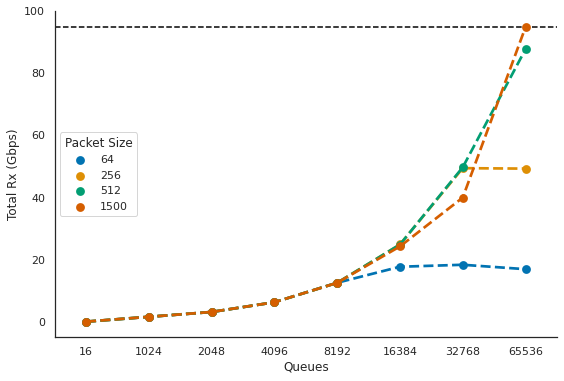

In [3]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[1.5*FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64
fig1 = sns.pointplot(
    data=mc_61_df,
    x='queues',
    y = mc_61_df['total_rx_L1']/(10**9),
    #y=mc_61_df["total_rx_pps"] / (10**6),
    hue="packet_size",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=True,
    linestyles="--",
   # linewidth=0.005,
    
    # hue_order = [64, 256, 512, 1500],
)
ax1.set(
    ylabel="Total Rx (Gbps)",
    xlabel="Queues",
   ylim = [-5, 100]
)
plt.setp(fig.lines, linewidth=0.75)
plt.axhline(y=95, color='black', linestyle='--')
plt.legend(title='Packet Size')

sns.despine()

# fig.savefig("../output_figures/intel_original.pdf")

In [132]:
mc_61_df.groupby(['queues', 'packet_size'])["total_rx_pps"].describe()/(10**6)

count       mean       std        min        25%  \
queues packet_size                                                        
16     64           0.000003   0.069544  0.000218   0.069394   0.069418   
       256          0.000003   0.021857  0.000055   0.021824   0.021825   
       512          0.000003   0.007620  0.006599   0.000000   0.005714   
       1500         0.000003   0.004059  0.000009   0.004051   0.004055   
1024   64           0.000003   2.257145  0.001493   2.256255   2.256283   
       256          0.000003   0.710256  0.001575   0.709183   0.709352   
       512          0.000003   0.371150  0.000453   0.370758   0.370902   
       1500         0.000003   0.130658  0.000211   0.130431   0.130564   
2048   64           0.000003   4.477545  0.001381   4.476026   4.476954   
       256          0.000003   1.411908  0.000682   1.411487   1.411515   
       512          0.000003   0.734902  0.001222   0.734137   0.734197   
       1500         0.000003   0.258763  0.000506   0.258178   0.258615   
4096   64           0.000003   8.934930  0.021300   8.912170   8.925204   
       256          0.000003   2.806450  0.005899   2.799640   2.804703   
       512          0.000003   1.465519  0.003835   1.462997   1.463313   
       1500         0.000003   0.516099  0.000077   0.516052   0.516054   
8192   64           0.000003  17.844377  0.051129  17.785360  17.828916   
       256          0.000003   5.591473  0.008737   5.585742   5.586444   
       512          0.000003   2.926415  0.005796   2.919723   2.924689   
       1500         0.000003   1.029283  0.000823   1.028337   1.029010   
16384  64           0.000003  25.160714  0.018658  25.146208  25.150190   
       256          0.000003  11.111941  0.028451  11.080334  11.100160   
       512          0.000003   5.798475  0.013614   5.787471   5.790863   
       1500         0.000003   1.990031  0.043420   1.948911   1.967331   
32768  64           0.000003  26.065752  0.112973  25.935302  26.033116   
       256          0.000003  22.075597  0.041283  22.037512  22.053662   
       512          0.000003  11.596176  0.031072  11.560508  11.585579   
       1500         0.000003   3.278438  0.050743   3.223028   3.256337   
65536  64           0.000003  24.046553  0.020395  24.028448  24.035506   
       256          0.000003  22.010076  0.094004  21.920588  21.961102   
       512          0.000003  20.463109  0.128391  20.321708  20.408468   
       1500         0.000003   7.779798  0.021557   7.755061   7.772417   

                          50%        75%        max  
queues packet_size                                   
16     64            0.069443   0.069618   0.069794  
       256           0.021826   0.021873   0.021920  
       512           0.011428   0.011430   0.011433  
       1500          0.004059   0.004064   0.004068  
1024   64            2.256312   2.257591   2.258869  
       256           0.709520   0.710792   0.712064  
       512           0.371046   0.371346   0.371646  
       1500          0.130697   0.130772   0.130847  
2048   64            4.477882   4.478304   4.478726  
       256           1.411542   1.412119   1.412695  
       512           0.734258   0.735285   0.736311  
       1500          0.259053   0.259055   0.259057  
4096   64            8.938238   8.946310   8.954382  
       256           2.809766   2.809855   2.809945  
       512           1.463628   1.466780   1.469932  
       1500          0.516057   0.516122   0.516187  
8192   64           17.872472  17.873885  17.875298  
       256           5.587147   5.594338   5.601529  
       512           2.929655   2.929760   2.929866  
       1500          1.029683   1.029756   1.029829  
16384  64           25.154172  25.167967  25.181762  
       256          11.119985  11.127745  11.135504  
       512           5.794254   5.803977   5.813700  
       1500          1.985750   2.010591   2.035433  
32768  64           26.130930  26.130977  26.131024  
       256    

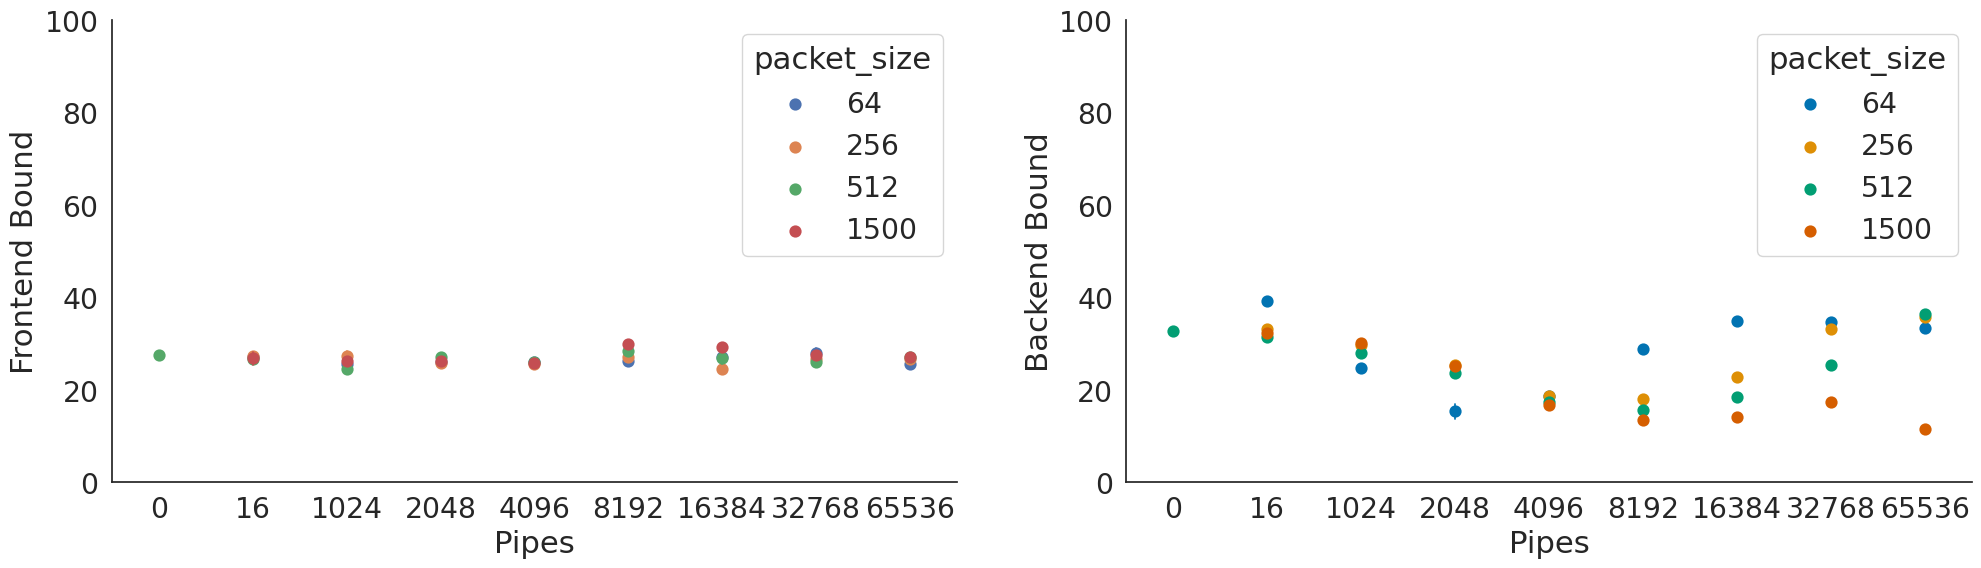

In [78]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[4*FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64

#ax1.set_xscale('symlog')

fig = sns.pointplot(
    data=mc_61_df,
    x="queues",
    y = 'Frontend Bound',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="packet_size",
    units="units",
    #estimator = None,
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=False,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
   # ylabel="Total Rx (Mpps)",
    xlabel="Pipes",
   # title="Misses\nPkt size = 64 B",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=mc_61_df,
x="queues",  
    y = 'Backend Bound',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="packet_size",
    units="units",
    #estimator = None,
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=False,
    linestyle="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    #ylabel="Total Rx (Mpps)",
    xlabel="Pipes",
    #title="Drops\nPkt size = 64 B",
    ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

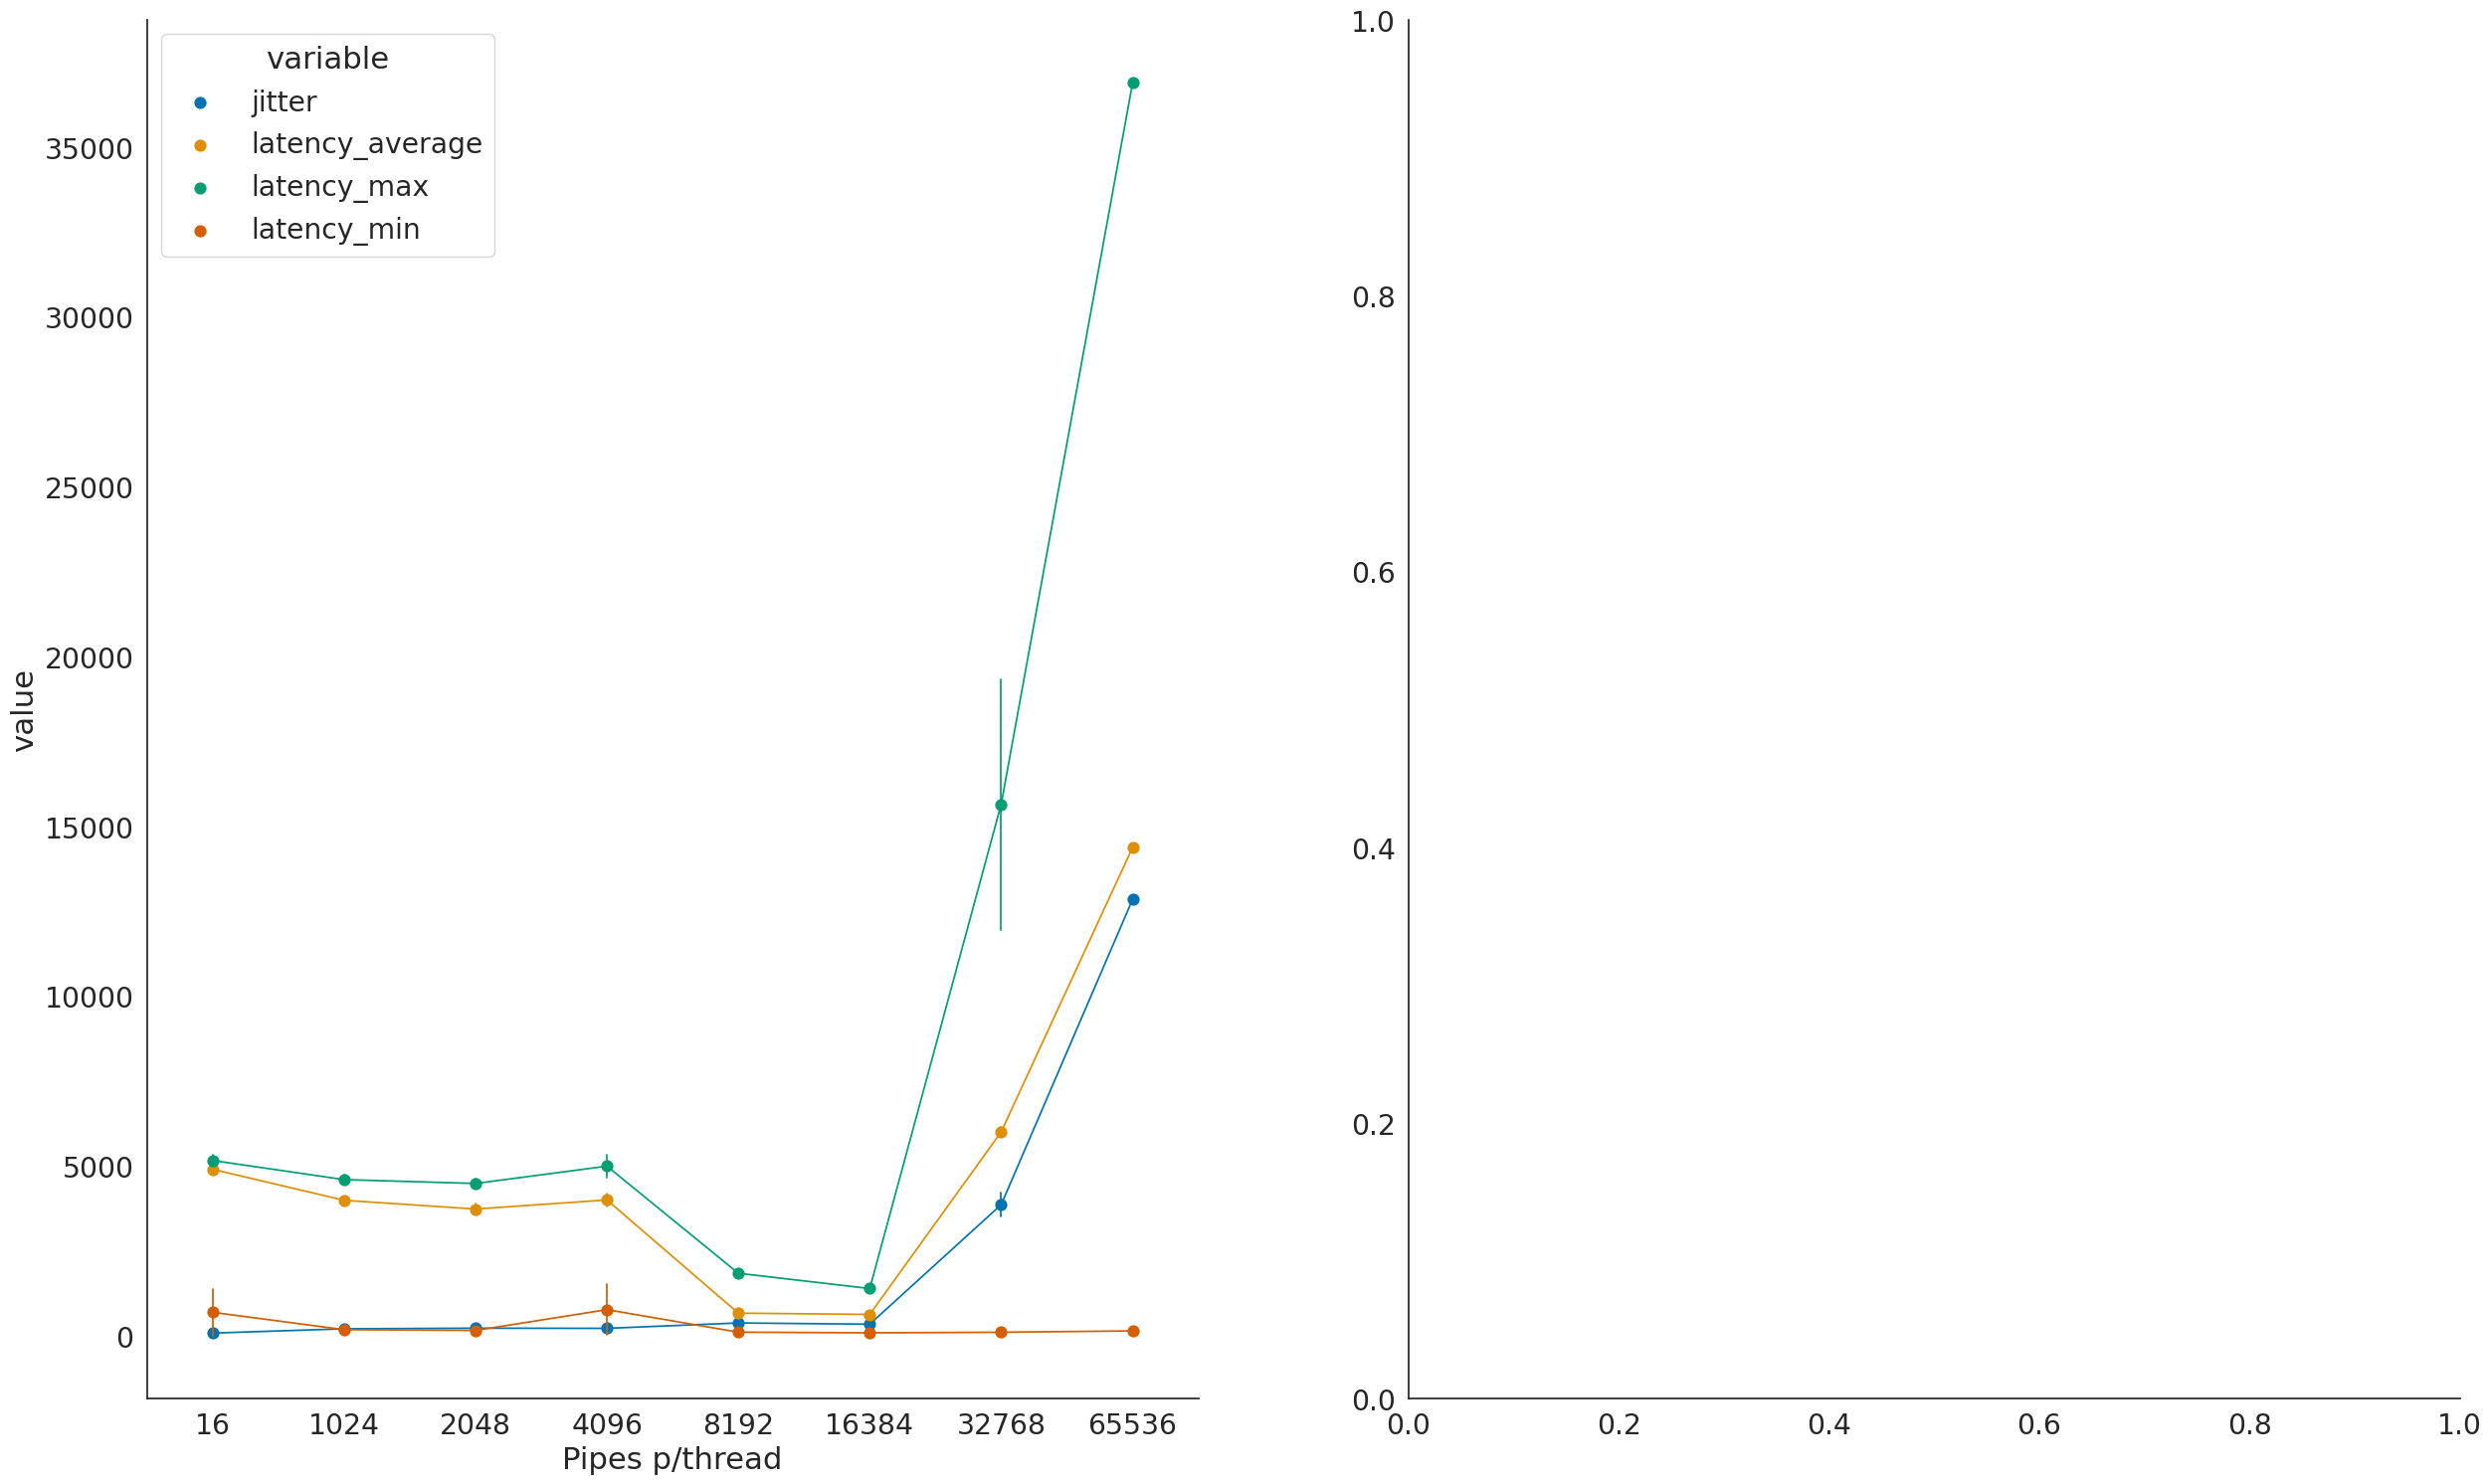

In [105]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64
latency_df = pd.melt(
    mc_61_df,
    id_vars = ['queues', 'units', 'packet_size'],
    #value_vars = ['L1 Bound','L2 Bound','L3 Bound','Memory Bound'],
    value_vars = ['jitter','latency_average','latency_max','latency_min' ]
)

#ax1.set_xscale('symlog')
fig = sns.pointplot(
    data=latency_df[latency_df['packet_size'] == 256],
    x="queues",
    y ='value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    style = 'nworkers',
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    #ylabel="% Access",
    xlabel="Pipes p/thread",
   # title="Misses\nPkt size = 64 B",
   # ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

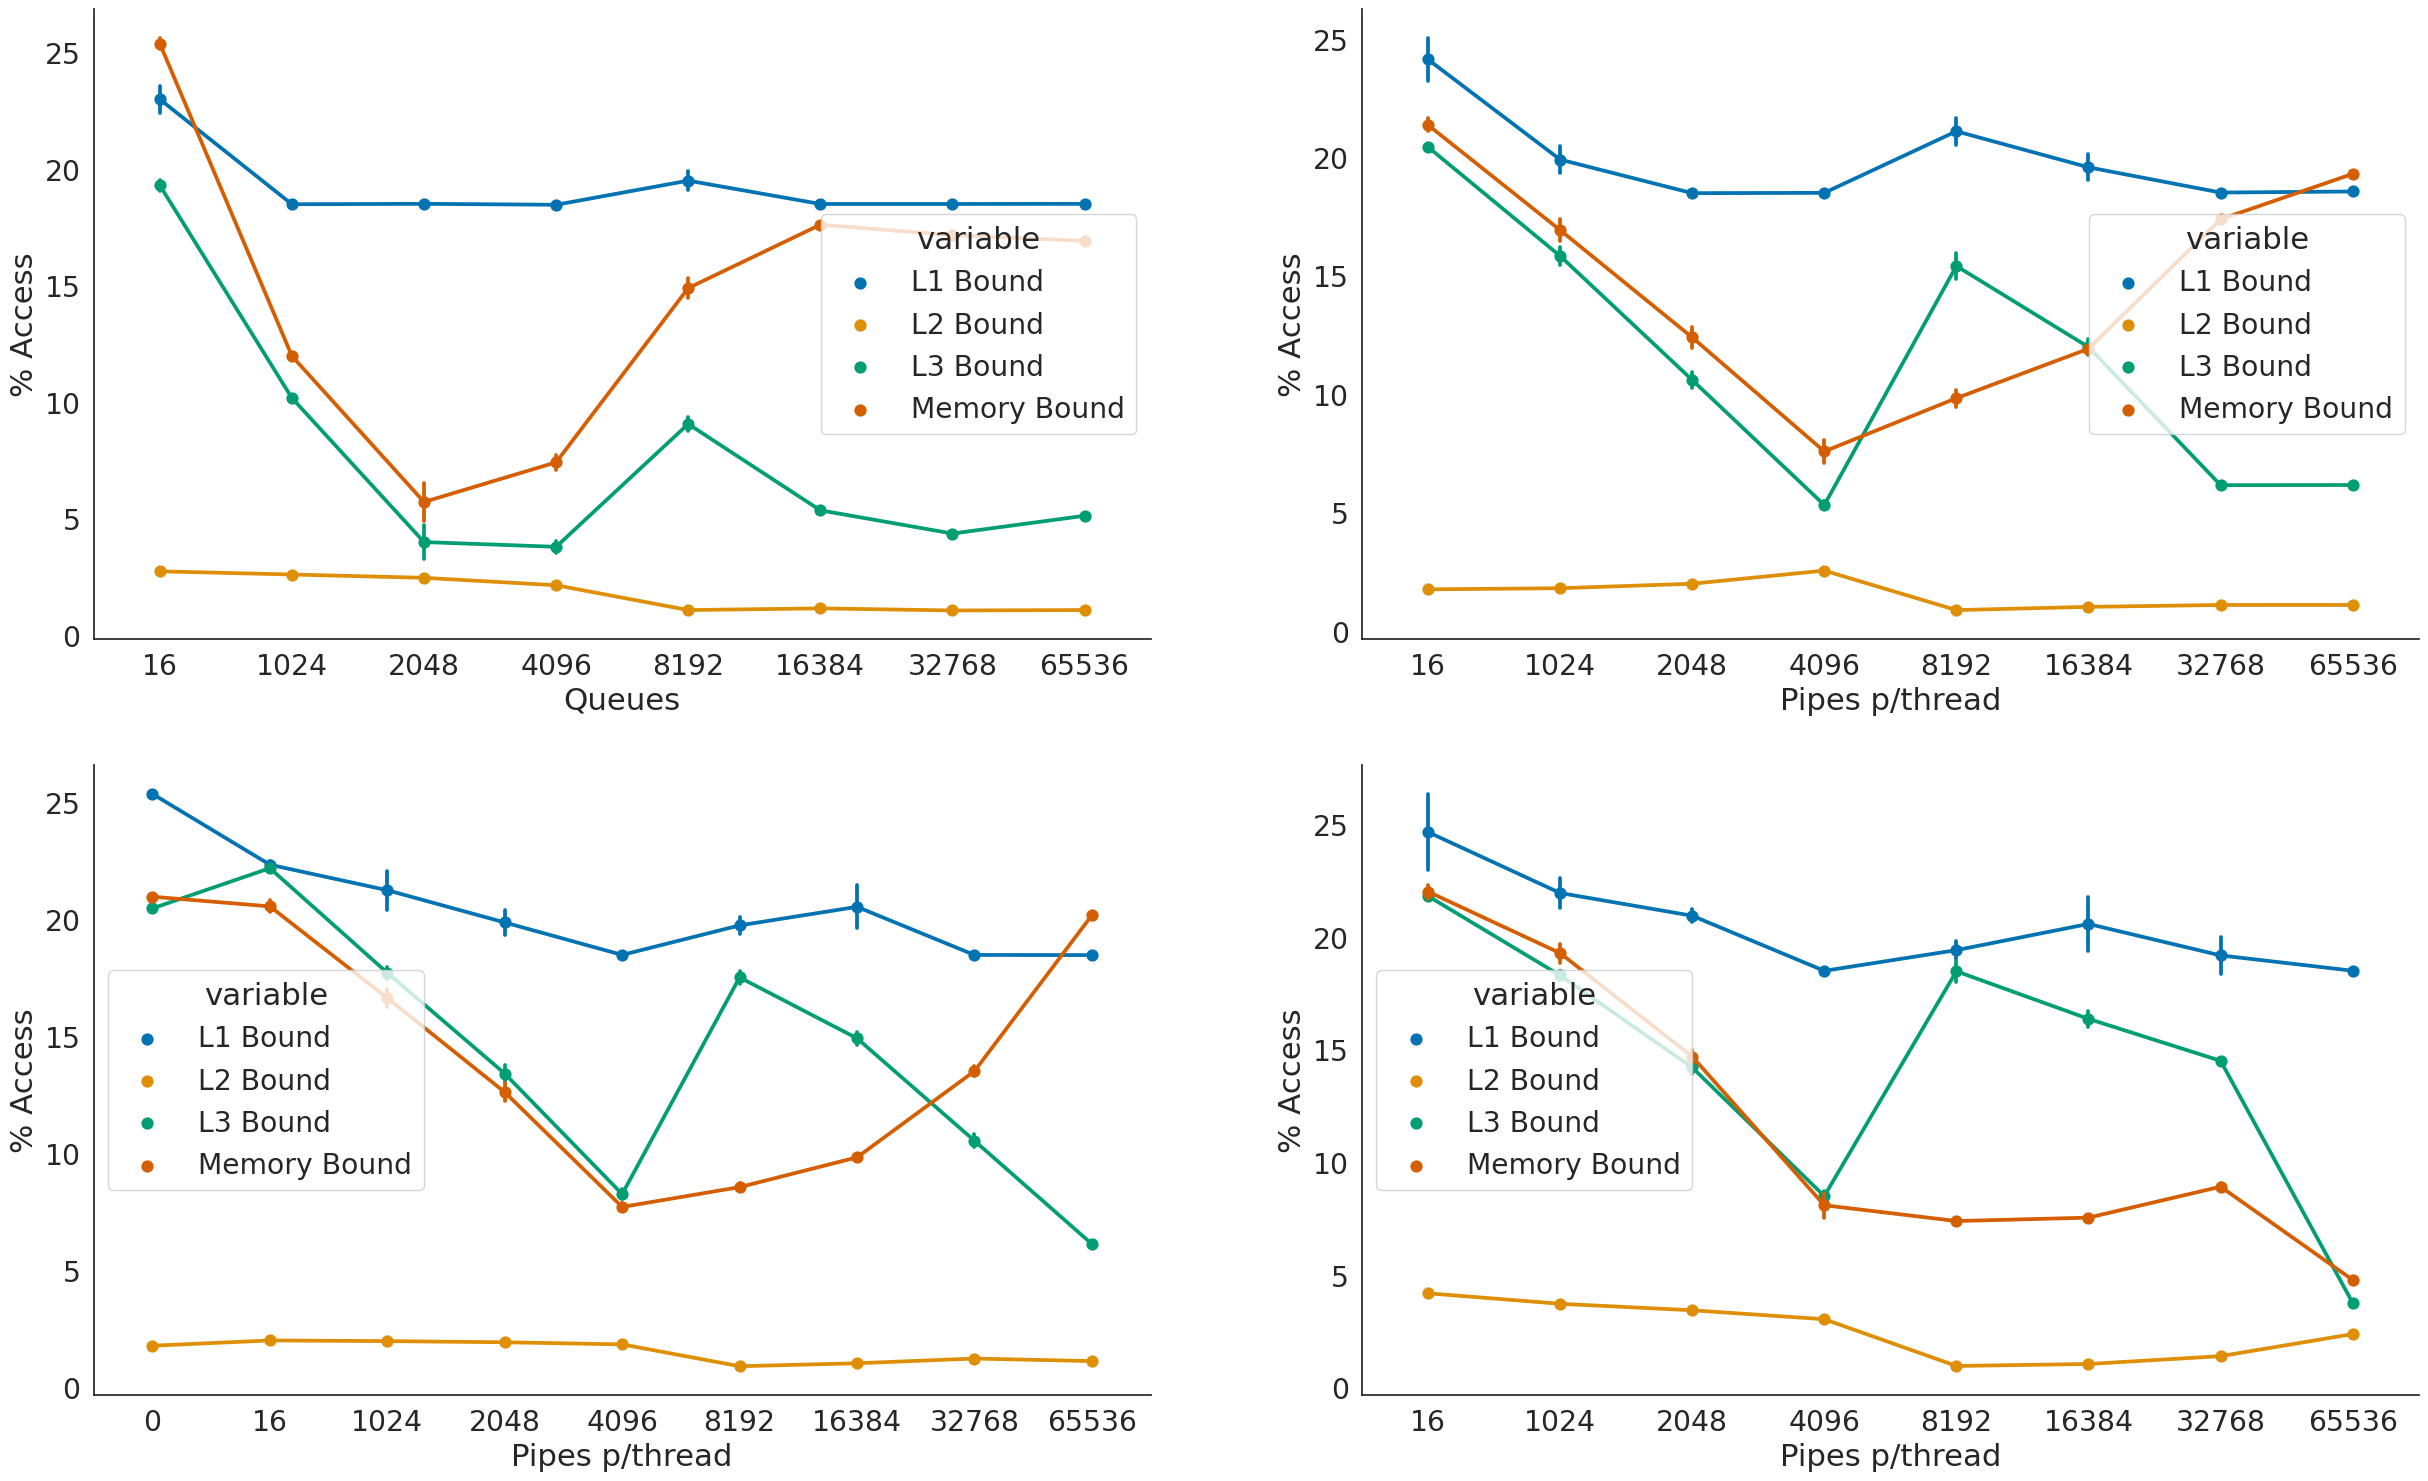

In [101]:
%matplotlib inline
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

accesses_df = pd.melt(
    mc_61_df,
    id_vars = ['queues', 'units', 'packet_size'],
    value_vars = ['L1 Bound','L2 Bound','L3 Bound','Memory Bound'],
    # value_vars = ['L1 Bound']
)

p_df = accesses_df[accesses_df['packet_size'] == 64]
fig1 = sns.pointplot(
    data=p_df,
    x="queues",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
)
ax1.set(
    ylabel="% Access",
    xlabel="Queues",
   # title="Misses\nPkt size = 64 B",
   # ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

p_df = accesses_df[accesses_df['packet_size'] == 256]
#ax1.set_xscale('symlog')
fig2 = sns.pointplot(
    data=p_df,
    x="queues",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    style = 'nworkers',
    #estimator = None,
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)
ax2.set(
    ylabel="% Access",
    xlabel="Pipes p/thread",
   # title="Misses\nPkt size = 64 B",
   # ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

p_df = accesses_df[accesses_df['packet_size'] == 512]
#ax1.set_xscale('symlog')
fig3 = sns.pointplot(
    data=p_df,
    x="queues",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    style = 'nworkers',
    #estimator = None,
    ax=ax3,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)
ax3.set(
    ylabel="% Access",
    xlabel="Pipes p/thread",
   # title="Misses\nPkt size = 64 B",
   # ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)


p_df = accesses_df[accesses_df['packet_size'] == 1500]
#ax1.set_xscale('symlog')
fig4 = sns.pointplot(
    data=p_df,
    x="queues",
    y = 'value',
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    style = 'nworkers',
    #estimator = None,
    ax=ax4,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)
ax4.set(
    ylabel="% Access",
    xlabel="Pipes p/thread",
   # title="Misses\nPkt size = 64 B",
   # ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)




sns.despine()

### WRR vs SP

In [2]:
measurements = list()
experiment_labels = [
    #'hqos_max-ndr-4flow',
    #'hqos_max-ndr-wrr'
]

for experiment in experiment_labels:
    
    output_dir = f"../output/{experiment}"
    
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        calls = 0
        no_buf = 0
        vector_rate = 0.0
        nworkers = 0
        
        for file in files:
            none, label, packet_size, repeat = direc.replace(output_dir, "").split("/")
            
            if "average" in file:
                perfstat = pd.read_csv(direc + "/" + file, index_col = 'metrics')


            if "vpp" in file:
                with open(direc + "/" + file, "r", encoding="utf8", errors="ignore") as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])

                        if (
                            "/interfaces/dev0/rx-no-buf" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            no_buf = int(p[3])

                        if "/err/dev1-tx/Tx" in p and "2]:" in p[2] and "[0" in p[0]:
                            drops = int(p[3])

                        if (
                            "/nodes/dev1-output/vectors" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            vectors = int(p[3])

                        if "/sys/vector_rate" in p:
                            vector_rate = float(p[0])
                        
                        if "/sys/num_worker_threads" in p:
                            nworkers = float(p[0])

                        if (
                            "/nodes/dev1-output/calls" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            calls = int(p[3])

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = json.loads(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue

        total_errors = misses + drops + no_buf
        metric = 'p95'
        measurements.append(
            {
                "total_rx_L1": t["results"]["total_tx_L1"],
                "total_tx_L1": int(t["results"]["total_rx_L1"]),
                "total_tx_pps": int(t["results"]["tx_pps"]),
                "total_rx_pps": int(t["results"]["rx_pps"]),
                "flows": int(label),
                'SP': 'SP' if 'wrr' not in experiment else 'WRR',
                #'disabled': 'disabled' if 'disabled' in experiment else 'bypass',
                'nworkers': nworkers,
                "packet_size": int(packet_size),
                "misses": misses,
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,
                "vector_rate": vector_rate,
                "call": calls,
                
                'IPC': perfstat.loc['metric_kernel_CPI', metric],
                'Frontend Bound': perfstat.loc['metric_TMA_Frontend_Bound(%)',metric],
                'Backend Bound': perfstat.loc['metric_TMA_Backend_Bound(%)', metric],
                'Cache Bound': perfstat.loc['metric_TMA_..Memory_Bound(%)', metric],
                'Core Bound': perfstat.loc['metric_TMA_..Core_Bound(%)', metric],
                'Memory Bound': perfstat.loc['metric_TMA_....MEM_Bound(%)', metric],
                'DTLB load miss': perfstat.loc['metric_DTLB load miss latency (in core clks)', metric],
                
                'L1 Bound': perfstat.loc['metric_TMA_....L1_Bound(%)', metric],
                'L2 Bound': perfstat.loc['metric_TMA_....L2_Bound(%)', metric],
                'L3 Bound': perfstat.loc['metric_TMA_....L3_Bound(%)',metric],

            }
        )
qdisc_df = pd.DataFrame(measurements)


In [3]:
qdisc_df

,total_rx_L1,total_tx_L1,total_tx_pps,total_rx_pps,flows,SP,nworkers,packet_size,misses,drops,...,IPC,Frontend Bound,Backend Bound,Cache Bound,Core Bound,Memory Bound,DTLB load miss,L1 Bound,L2 Bound,L3 Bound
0,778166696.0,259373310,1157986,385972,1,SP,2.0,64,245569119,5301,...,1.633251,21.195048,34.773009,14.283074,20.573796,0.582239,5628.667130,8.471236,1.146340,2.344902
1,778540896.0,260415188,1158543,387522,1,SP,2.0,64,243553603,4141,...,1.693956,21.237407,34.661479,14.269349,20.481871,0.585846,1914.020758,8.224588,1.156588,2.725671
2,775277684.0,258745872,1153687,385038,1,SP,2.0,64,228282659,2849,...,1.702190,21.388639,34.789672,14.742045,20.050800,0.778916,10599.029324,8.790586,1.098143,2.829613
3,779651292.0,259246428,1160195,385783,1024,SP,2.0,64,243171640,4429,...,1.551413,21.391515,34.722434,14.212497,20.531077,0.583479,11420.163750,8.437630,1.133749,2.385508
4,776712404.0,258893518,1155822,385258,1024,SP,2.0,64,245024622,5160,...,1.658069,21.134332,34.761560,14.230206,20.529470,0.572981,20470.873750,8.005725,1.114146,2.736666
5,777526512.0,260104698,1157033,387060,1024,SP,2.0,64,279501244,6101,...,1.670961,23.009966,41.944211,21.303975,21.394332,3.770429,7843.844809,10.689571,1.459895,2.151856
6,778097784.0,259384834,1157872,385989,128,SP,2.0,64,277565964,3461,...,1.667406,21.373942,34.571161,14.251891,20.444343,1.962323,3440.881305,8.639951,1.196636,2.293766
7,777918856.0,259302375,1157617,385867,128,SP,2.0,64,245935959,5755,...,1.682632,21.988050,34.781992,14.497891,20.359723,0.617485,10176.309120,8.709996,1.128344,2.701962
8,774862640.0,258272062,1153069,384334,128,SP,2.0,64,242468201,2937,...,1.624444,21.194670,34.976420,14.501882,20.547387,0.591755,4658.168317,8.689006,1.127305,2.434230
9,781195632.0,260452421,1162493,387578,16,SP,2.0,64,243612115,5227,...,1.587362,21.761178,34.596215,14.134015,20.515486,0.606884,5709.014198,8.081250,1.157724,2.644101


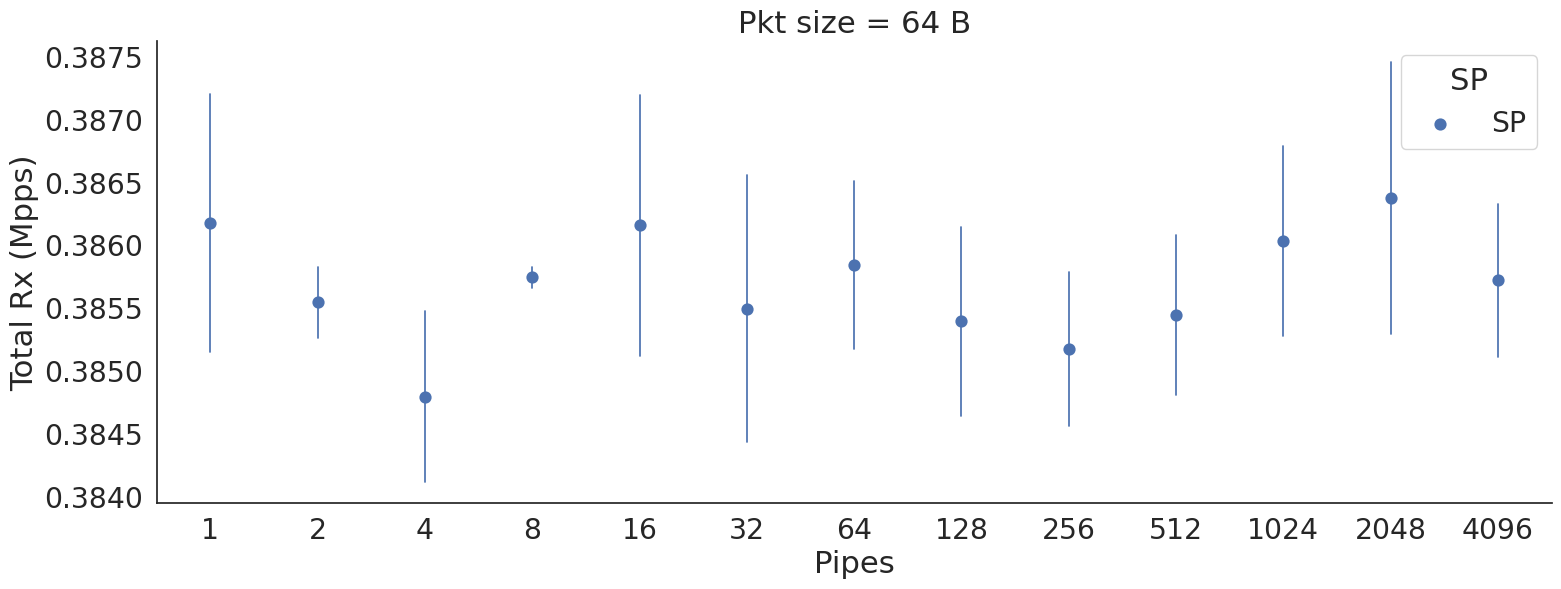

In [5]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[3*FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64

fig = sns.pointplot(
    data=qdisc_df,
    x="flows",
   #y = qdisc_df['total_rx_L1']/(10**9),
    y=qdisc_df["total_rx_pps"] / (10**6),
    hue="SP",
    units="units",
    #estimator = None,
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    #markersize=1,
    #errorwidth=3,
    join=False,
    linestyle="--",
    linewidth=0.005,
    
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Pipes",
    title="Pkt size = 64 B",
    #ylim = [0, 13],
)
plt.setp(fig.lines, linewidth=1.25)
sns.despine()

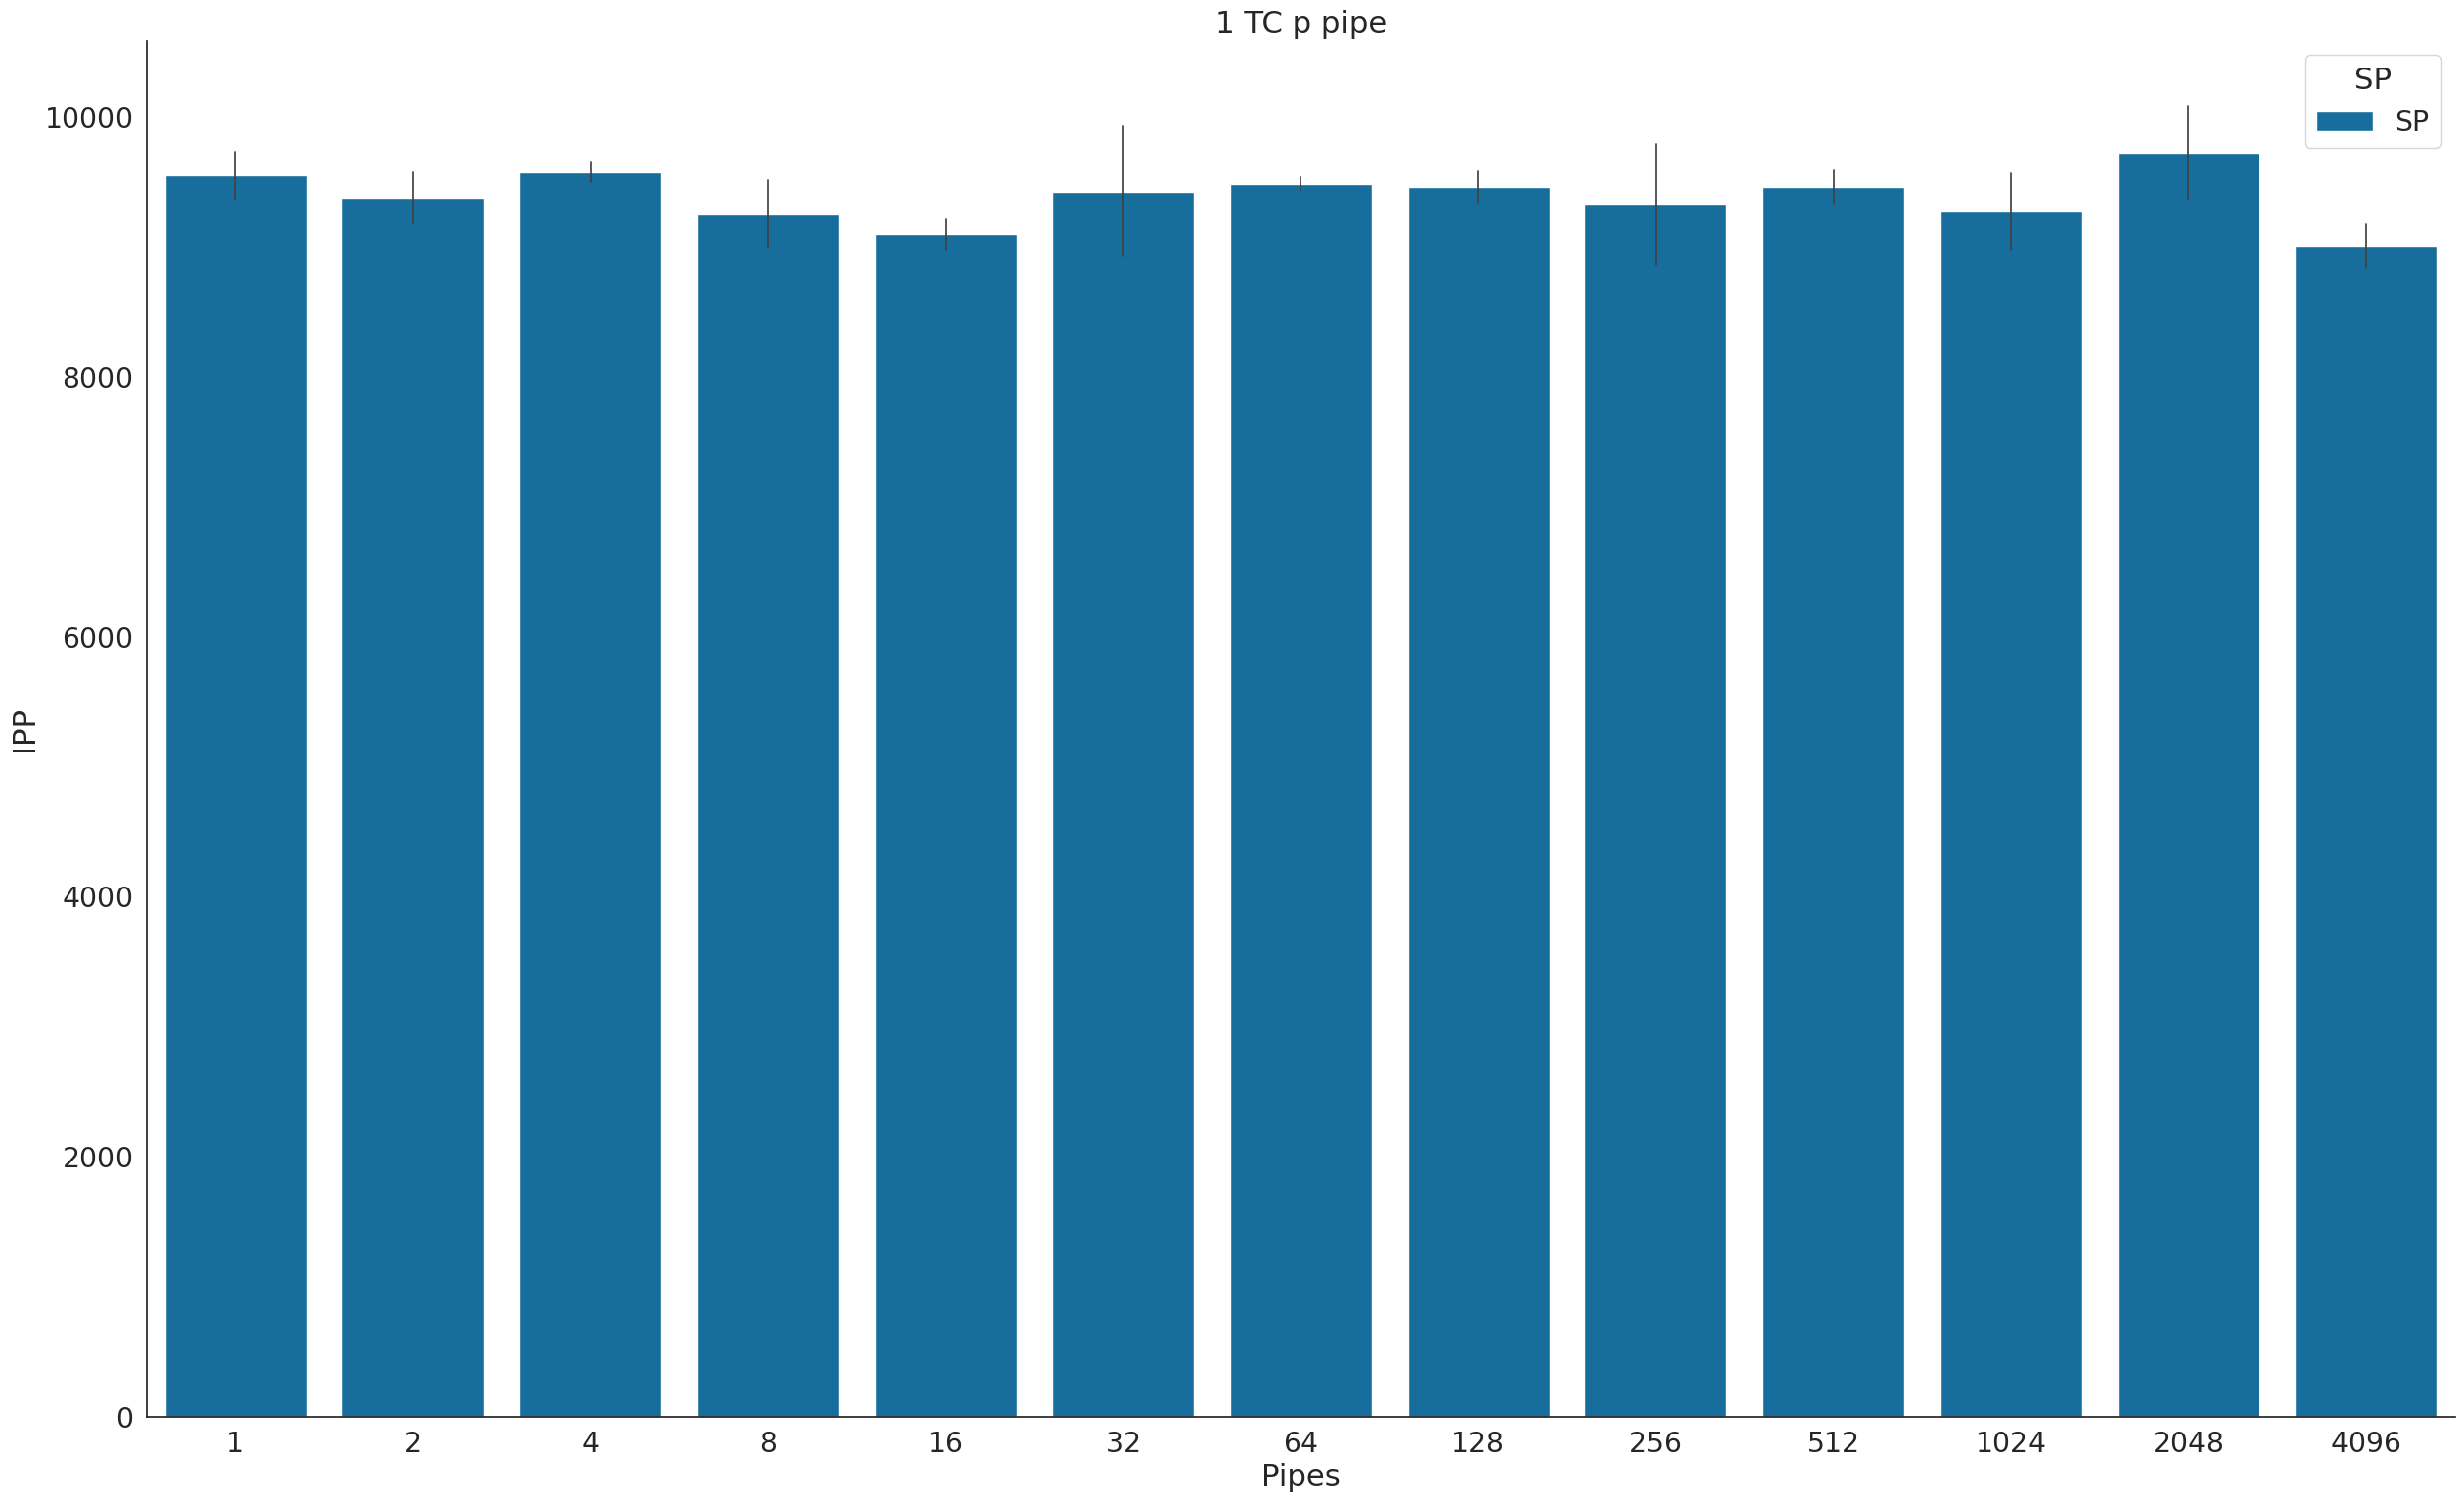

In [6]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[5*FIGSIZE[0], 3*FIGSIZE[1]])

PKT_SIZE = 64

p_df = qdisc_df
fig = sns.barplot(
    data=p_df,
    x="flows",
    y=((2.2*10**9)/ p_df["total_rx_pps"])*p_df["IPC"],
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="SP",
    units="units",
    #estimator = None,
    ax=ax1,
    palette="colorblind",
    ci="sd",
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=True,
    #linestyle="--",
    #linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="IPP",
    xlabel="Pipes",
    title="1 TC p pipe",
   # ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

### Latency

In [89]:
measurements = list()
experiment_labels = ["latency-tradeoff-4core"]

label_to_flows = {
    'single': 4096,
    'local-1stream': 8192,
    'local-2stream': 12288,
    'local-3stream': 16384,
}

for experiment in experiment_labels:
    output_dir = f"../output/{experiment}"

    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue
            
        if 'remote' in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        calls = 0
        no_buf = 0
        vector_rate = 0.0
        nworkers = 0

        for file in files:
            none, label, packet_size, repeat = direc.replace(output_dir, "").split("/")

            if "average" in file:
                perfstat = pd.read_csv(direc + "/" + file, index_col="metrics")

            if "vpp" in file:
                with open(
                    direc + "/" + file, "r", encoding="utf8", errors="ignore"
                ) as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])

                        if (
                            "/interfaces/dev0/rx-no-buf" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            no_buf = int(p[3])

                        if "/err/dev1-tx/Tx" in p and "2]:" in p[2] and "[0" in p[0]:
                            drops = int(p[3])

                        if (
                            "/nodes/dev1-output/vectors" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            vectors = int(p[3])

                        if "/sys/vector_rate" in p:
                            vector_rate = float(p[0])

                        if "/sys/num_worker_threads" in p:
                            nworkers = float(p[0])

                        if (
                            "/nodes/dev1-output/calls" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            calls = int(p[3])

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = ast.literal_eval(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue

        metric = "max"
        total_errors = misses + drops
        pkt_loss = t["total"]["opackets"] - t["total"]["ipackets"]
        latency = t["latency"][0]["latency"]
        histogram = t["latency"][0]["latency"]["histogram"]

        measurements.append(
            {
                "total_rx_L1": t["total"]["rx_bps_L1"],
                "total_tx_L1": int(t["total"]["tx_bps_L1"]),
                "rx_util": t["total"]["rx_util"],
                "tx_util": int(t["total"]["tx_util"]),
                "total_tx_pps": int(t["total"]["tx_pps"]),
                "total_rx_pps": int(t["total"]["rx_pps"]),
                "lost_packets": pkt_loss,
                "jitter": latency["jitter"],
                "latency_avg": latency["average"],
                "latency_max": latency["total_max"],
                "latency_min": latency["total_min"],
                "histogram": histogram,
                "nworkers": nworkers,
                "packet_size": int(packet_size),
                "label": label,
                "misses": misses,
                
                'flows': label_to_flows[label],
                #'queues': int(int(flows)*nworkers/2*4),
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                # "no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,
                # "loops": loops_p_worker,
                "IPC": perfstat.loc["metric_IPC", metric],
                "CPI": perfstat.loc["metric_CPI", metric],
                "Frontend Bound": perfstat.loc["metric_TMA_Frontend_Bound(%)", metric],
                "Backend Bound": perfstat.loc["metric_TMA_Backend_Bound(%)", metric],
                "Memory Bound": perfstat.loc["metric_TMA_..Memory_Bound(%)", metric],
                "Core Bound": perfstat.loc["metric_TMA_..Core_Bound(%)", metric],
                "External Memory Bound": perfstat.loc[
                    "metric_TMA_....MEM_Bound(%)", metric
                ],
                "DTLB load miss": perfstat.loc[
                    "metric_DTLB load miss latency (in core clks)", metric
                ],
                "Bad Speculation": perfstat.loc[
                    "metric_TMA_Bad_Speculation(%)", metric
                ],
                "Retiring": perfstat.loc["metric_TMA_Retiring(%)", metric],
                "Ports Utilization": perfstat.loc[
                    "metric_TMA_......Ports_Utilized_3m(%)", metric
                ],
                "L1 Bound": perfstat.loc["metric_TMA_....L1_Bound(%)", metric],
                "L2 Bound": perfstat.loc["metric_TMA_....L2_Bound(%)", metric],
                "L3 Bound": perfstat.loc["metric_TMA_....L3_Bound(%)", metric],
                # "vector_rate": vector_rate,
            }
        )
        latency_df = pd.DataFrame(measurements)

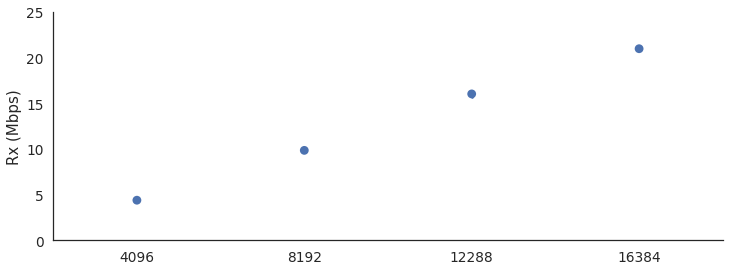

In [90]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=[2 * FIGSIZE[0], 0.7 * FIGSIZE[1]])

fig1 = sns.pointplot(
    data=latency_df,
    x="flows",
    y=latency_df["rx_util"],
    # y=multicore_measures_df["total_rx_L1"] / (10**9),
    # hue="variable",
    units="units",
    # style = 'nworkers',
    # estimator = None,
    ax=ax1,
    # palette="colorblind",
    ci="sd",
    # err_style="bars",
    join=False,
    # markersize=1,
    # errorwidth=3,
    # join=True,
    linestyles="--",
    # linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Rx (Mbps)",
    xlabel="",
    # title="Misses\nPkt size = 64 B",
    ylim=[0, 25],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()
# fig.savefig("../output_figures/latency_tput_deviation.pdf")

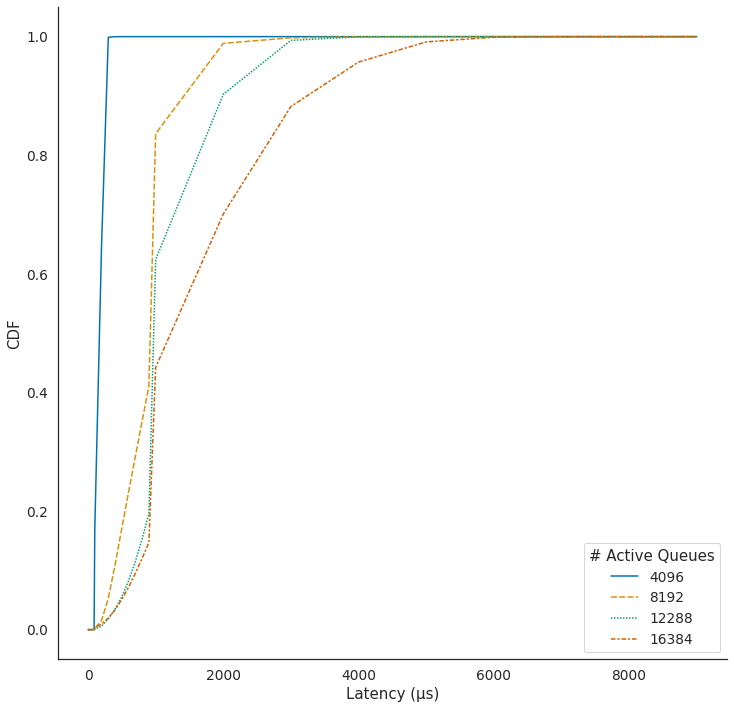

In [95]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[2*FIGSIZE[0], 2*FIGSIZE[1]])

array = list(pd.json_normalize(latency_df["histogram"]).columns.values)
histogram_df = pd.json_normalize(latency_df["histogram"])
histogram_df = histogram_df.merge(
    latency_df["flows"], left_index=True, right_index=True
)

total_df = histogram_df.groupby("flows").sum().div(3).reset_index()

# total_df.columns = ['remote25G', 'remote50G', 'remote75G', 'single']
total_df = pd.melt(total_df, id_vars="flows")
hist = []
for i, g in total_df.groupby("flows"):
    obj = (
        g.set_index("variable").sort_index()["value"].cumsum()
        / g.set_index("variable").sort_index()["value"].sum()
    )
    a = {}
    a['total'] = obj.to_dict()#.drop_duplicates()
    a['flows'] = i
    hist.append(a)

t = pd.json_normalize(pd.DataFrame(hist)['total']).transpose()
t.columns = label_to_flows.values()

sns.lineplot(
    data = t,
    linestyle= '-',
    palette='colorblind',
)

ax1.set(
    xlabel="Latency (μs)",
    ylabel="CDF",
    # title="Misses\nPkt size = 64 B",
    # ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)
plt.legend(title = "# Active Queues")

sns.despine()

# fig.savefig("../output_figures/latency_queues.png")

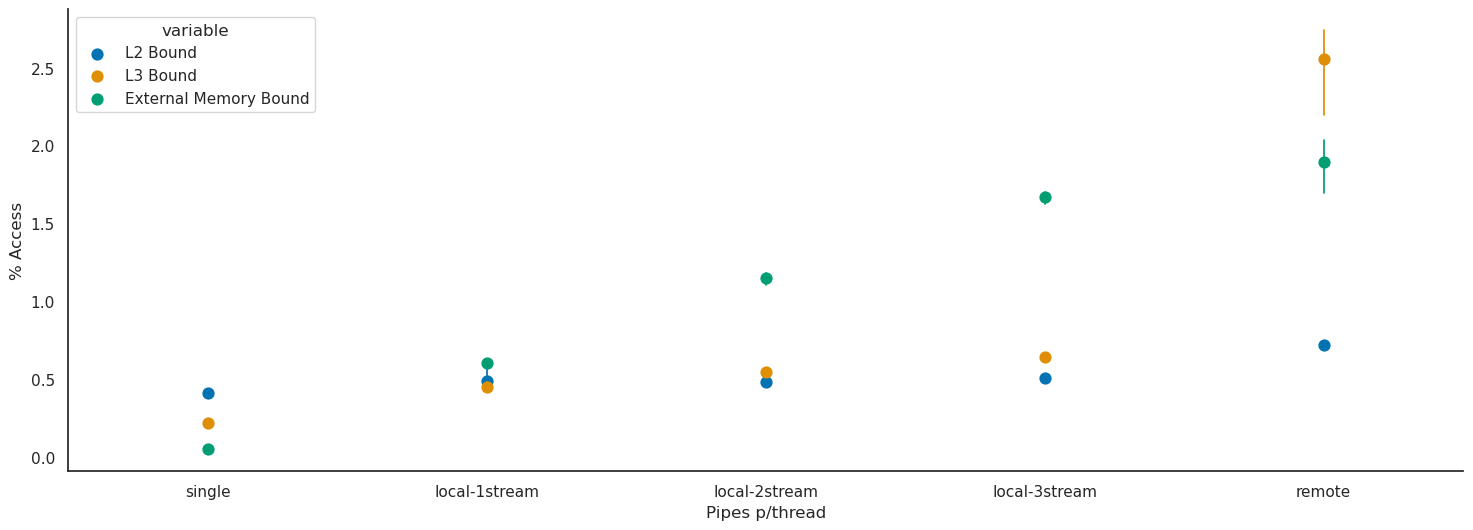

In [573]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[3 * FIGSIZE[0], FIGSIZE[1]])

PKT_SIZE = 64

p_df = pd.melt(
    latency_df,
    id_vars=["label", "units"],
    value_vars=["L2 Bound", "L3 Bound", "External Memory Bound"],
    # value_vars = ['Memory Bound']
)

# ax1.set_xscale('symlog')
fig = sns.pointplot(
    data=p_df,
    x="label",
    y="value",
    # y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    # estimator = None,
    ax=ax1,
    palette="colorblind",
    # markersize=1,
    # errorwidth=3,
    join=False,
    # linestyle="--",
    # linewidth=0.005,
    # hue_order = ['single', 'remote25G', 'remote50G', 'remote75G', 'local-1stream', 'local-2stream', 'local-3stream'],
)

ax1.set(
    ylabel="% Access",
    xlabel="Pipes p/thread",
    # title="Misses\nPkt size = 64 B",
    # ylim= [0,100],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

# Setup

We testing VPP at commit 2b5bc3bce6fc5d4a2bbe1342522c62f9da0efd19.

Grub cmdline parameters

```
ST: GRUB_CMDLINE_LINUX_DEFAULT="crashkernel=auto isolcpus=8-27,29-55 iommu=pt intel_iommu=on default_hugepagesz=1G hugepagesz=1G hugepages=32 nohz_full=8-27,29-55 tsc=reliable irqaffinity=0 rcu_nocbs=8-27,29-55 rcu_nocbs_poll idle=poll rsc=reliable mce=ignore_ce audit=0 nmi_watchdog=0 skew_tick=1 nosoftlookup nosmt"
SMT: GRUB_CMDLINE_LINUX_DEFAULT="crashkernel=auto isolcpus=8-27,64-83,29-55,85-111 iommu=pt intel_iommu=on default_hugepagesz=1G hugepagesz=1G hugepages=32 nohz_full=8-27,64-83,29-55,85-111 tsc=reliable irqaffinity=0 rcu_nocbs=8-27,64-83,29-55,85-111 rcu_nocbs_poll idle=poll rsc=reliable mce=ignore_ce audit=0 nmi_watchdog=0 skew_tick=1 nosoftlookup" 
```

```
4: enp134s0f0: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP mode DEFAULT group default qlen 1000
    link/ether 40:a6:b7:0a:7f:18 brd ff:ff:ff:ff:ff:ff
    vf 0     link/ether 00:00:00:01:00:01 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 1     link/ether 00:00:00:01:00:02 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 2     link/ether c6:84:89:9d:96:e2 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 3     link/ether 82:a8:ee:9f:fa:78 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 4     link/ether 56:d7:48:ab:28:4d brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 5     link/ether 96:51:14:d4:e7:93 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 6     link/ether 12:c9:27:fb:39:45 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 7     link/ether f2:a8:44:71:f4:3c brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 8     link/ether c6:71:cc:d3:ec:d4 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 9     link/ether a2:0f:d6:44:a7:79 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 10     link/ether 1a:b1:54:53:9a:4b brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 11     link/ether 6a:3c:1b:ad:1b:be brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 12     link/ether da:90:04:23:eb:78 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
5: enp134s0f1: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP mode DEFAULT group default qlen 1000
    link/ether 40:a6:b7:0a:7f:19 brd ff:ff:ff:ff:ff:ff                                                                 
    vf 0     link/ether a6:b2:8b:f7:38:80 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 1     link/ether 6e:bd:8b:a0:c3:be brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 2     link/ether c6:6f:b7:15:e3:2f brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 3     link/ether 1e:90:a4:db:9c:73 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 4     link/ether e2:a0:b8:aa:6a:8e brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 5     link/ether be:31:2d:e5:d0:f8 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 6     link/ether b6:2c:04:8d:9e:3c brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 7     link/ether 4e:69:cc:9e:07:23 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 8     link/ether 52:a5:32:0f:b5:d7 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 9     link/ether d6:54:bd:02:4f:f3 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 10     link/ether 92:b3:64:66:db:b4 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 11     link/ether 42:8a:fd:a9:1e:12 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 12     link/ether 56:e4:5e:e2:6d:dd brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
```

```
unix {
  nodaemon
  interactive
  log /var/log/vpp.log
  full-coredump
  cli-listen /run/vpp/cli.sock
  # cli-listen 0.0.0.0:5002
  exec /etc/vpp/vpp_cli.conf.l2xc
}

api-trace {
  on
}

statseg {
  size 1G
}

socksvr {
  socket-name /run/vpp/api.sock
}

plugins {
  plugin default { disable }
  plugin dpdk_plugin.so { enable }
}

cpu {
  main-core 44
  corelist-workers 36
  # corelist-hqos-threads 37
}

memory {
  main-heap-size 500M
  main-heap-page-size 1G
}

dpdk {
  no-multi-seg
  no-tx-checksum-offload

  dev default {
    num-rx-desc 4096
    num-tx-desc 4096
    num-rx-queues 1
  }
  dev 0000:86:01.0 {
    name dev0
  }
  dev 0000:86:01.1 {
    name dev1
    # hqos {}
  }
}

logging {
  ## Available severity levels:
  ## emerg|alertcrit|err|warn|notice|info|debug|disabled

  default-log-level info
  default-syslog-log-level info
}

buffers {
   buffers-per-numa 256000
   default data-size 2048
   page-size default-hugepage
}

# statseg {
#    per-node-counters on
#  }
```

```
set int mac address dev0 00:00:00:01:00:01
set int mac address dev1 00:00:00:01:00:02
# set int mac address dev2 00:00:00:01:00:02
# set int mac address dev3 00:00:00:01:00:03
# set int mac address dev4 00:00:00:01:00:04
# set int mac address dev5 00:00:00:01:00:05
# set int mac address dev6 00:00:00:01:00:06
# set int mac address dev7 00:00:00:01:00:07
# set int mac address dev8 00:00:00:01:00:08
# set int mac address dev9 00:00:00:01:00:09
# set int mac address dev10 00:00:00:01:00:10
# set int mac address dev11 00:00:00:01:00:11

set interface l2 xconnect dev0 dev1
set interface l2 xconnect dev1 dev0

# set interface l2 xconnect dev2 dev3
# set interface l2 xconnect dev3 dev2

# set interface l2 xconnect dev4 dev5
# set interface l2 xconnect dev5 dev4

# set interface l2 xconnect dev6 dev7
# set interface l2 xconnect dev7 dev6

# set interface l2 xconnect dev8 dev9
# set interface l2 xconnect dev9 dev8
# 
# set interface l2 xconnect dev10 dev11
# set interface l2 xconnect dev11 dev10

set interface promiscuous off dev1
# set interface promiscuous off dev3
# set interface promiscuous off dev5
# set interface promiscuous off dev7
# set interface promiscuous off dev9
# set interface promiscuous off dev11

set interface state dev0 up
set interface state dev1 up
# set interface state dev2 up
# set interface state dev3 up
# set interface state dev4 up
# set interface state dev5 up
# set interface state dev6 up
# set interface state dev7 up
# set interface state dev8 up
# set interface state dev9 up
# set interface state dev10 up
# set interface state dev11 up

set interface rx-placement dev0 worker 0
set interface rx-placement dev1 worker 0
# set interface rx-placement dev2 worker 1
# set interface rx-placement dev3 worker 1
# set interface rx-placement dev4 worker 2
# set interface rx-placement dev5 worker 2
# set interface rx-placement dev6 worker 3
# set interface rx-placement dev7 worker 3
# set interface rx-placement dev8 worker 4
# set interface rx-placement dev9 worker 4
# set interface rx-placement dev10 worker 5
# set interface rx-placement dev11 worker 5

```

```

set int mac address dev0 00:00:00:01:00:01
set int mac address dev1 00:00:00:01:00:02
# set int mac address dev2 00:00:00:01:00:03
# set int mac address dev3 00:00:00:01:00:04
# set int mac address dev4 00:00:00:01:00:05
# set int mac address dev5 00:00:00:01:00:06
# set int mac address dev6 00:00:00:01:00:07
# set int mac address dev7 00:00:00:01:00:08

set interface ip address dev0 192.168.0.1/32
set interface ip address dev1 0.0.0.1/32
# set interface ip address dev2 192.168.0.2/32
# set interface ip address dev3 0.0.0.2/32
# set interface ip address dev4 192.168.0.3/32
# set interface ip address dev5 0.0.0.3/32
# set interface ip address dev6 192.168.0.4/32
# set interface ip address dev7 0.0.0.4/32

set interface state dev0 up
set interface state dev1 up
# set interface state dev2 up
# set interface state dev3 up
# set interface state dev4 up
# set interface state dev5 up
# set interface state dev6 up
# set interface state dev7 up

set ip neighbor dev0 192.168.0.0 00:00:00:00:0a:01
set ip neighbor dev1 0.0.0.11 00:01:00:00:00:02
ip route add 10.0.0.0/20 via 0.0.0.11 dev1

# set ip neighbor dev2 192.168.0.0 00:00:00:00:0a:01
# set ip neighbor dev3 0.0.0.31 00:01:00:00:00:02
# ip route add 10.1.0.0/20 via 0.0.0.31 dev3
# 
# set ip neighbor dev4 192.168.0.0 00:00:00:00:0a:01
# set ip neighbor dev5 0.0.0.51 00:01:00:00:00:02
# ip route add 10.2.0.0/20 via 0.0.0.51 dev5
# # 
# set ip neighbor dev6 192.168.0.0 00:00:00:00:0a:01
# set ip neighbor dev7 0.0.0.71 00:01:00:00:00:02
# ip route add 10.3.0.0/20 via 0.0.0.71 dev7
# 
set interface rx-placement dev0 worker 0
set interface rx-placement dev1 worker 0
# 
# set interface rx-placement dev2 worker 1
# set interface rx-placement dev3 worker 1
# # # 
# set interface rx-placement dev4 worker 2
# set interface rx-placement dev5 worker 2
# # 
# set interface rx-placement dev6 worker 3
# set interface rx-placement dev7 worker 3
```